# Fit Missing Mass Squared Distributions

In [1]:
import math
import ROOT

Welcome to JupyROOT 6.24/04


In [2]:
inFileName = "~/Analysis/ProtonTrackEfficiency/pmatt/trackeff_Proton_4pi.root"
histName = "MissingMass/MissingMassVsBeamEnergy_Missing"
inFile = ROOT.TFile(inFileName)
MM2vsBeamEnergyHist = inFile.Get(histName)

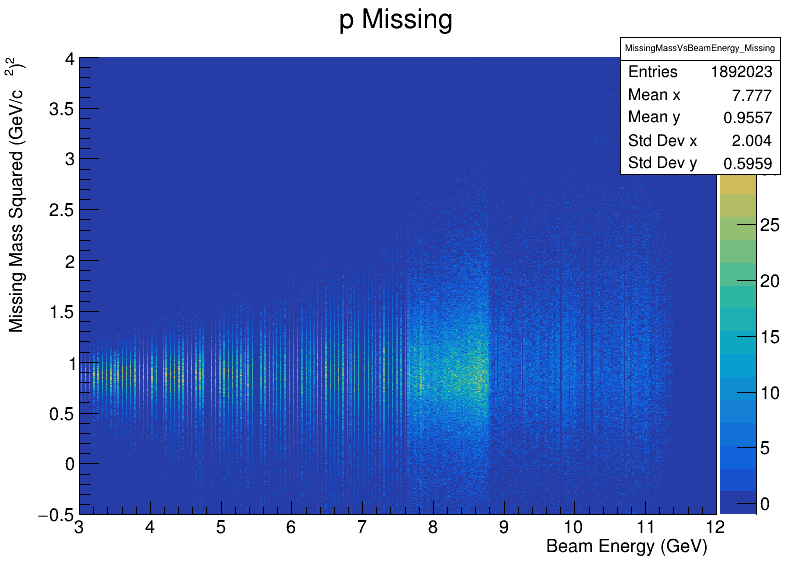

In [3]:
canv = ROOT.TCanvas("canv", "", 800, 600)
MM2vsBeamEnergyHist.Draw("COLZ")
canv.Draw()

Get missing mass squared distribution by projecting the 2D histogram and adjust binning

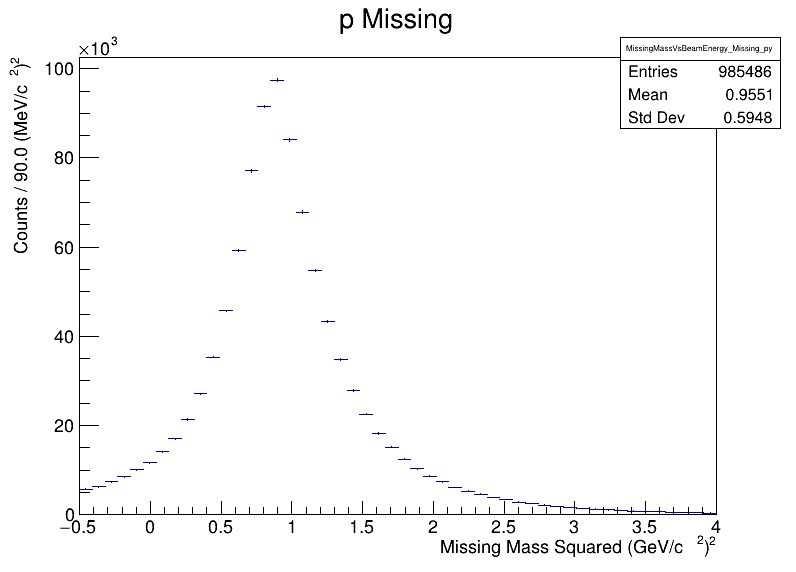

In [4]:
MM2Hist = MM2vsBeamEnergyHist.ProjectionY()
MM2Hist.Rebin(35)
MM2Hist.SetYTitle(f"Counts / {MM2Hist.GetBinWidth(1) * 1000}" + " (MeV/c^{2})^{2}")
MM2Hist.Draw()
canv.Draw()

Function that fits a missing mass squared distribution with a double Gaussian on top of a 2nd-order polynomial and returns `TFitResult object

In [5]:
# define fit function
# see https://root-forum.cern.ch/t/syntax-of-a-free-function-or-c-functor-for-tgraph-fitting/22292/3
# and https://root.cern/manual/python/#just-in-time-compilation-of-small-strings
ROOT.gROOT.LoadMacro("./doubleGaussianPol2.C+")
# Python callables need to exits in scope where where function is drawn
doubleGaussianPol2 = ROOT.doubleGaussianPol2()
signal = ROOT.doubleGaussianPol2(ROOT.doubleGaussianPol2.signal)
gaussian1 = ROOT.doubleGaussianPol2(ROOT.doubleGaussianPol2.gaussian1)
gaussian2 = ROOT.doubleGaussianPol2(ROOT.doubleGaussianPol2.gaussian2)
background = ROOT.doubleGaussianPol2(ROOT.doubleGaussianPol2.background)

# fit function to distribution
def fitMissingMassSquared(MM2Hist, fitRange = None, fixParValues = None, forceCommonGaussianMean = False):
  # construct fit function and set start parameters
  if fitRange is None:
    fitRange  = (MM2Hist.GetXaxis().GetXmin(), MM2Hist.GetXaxis().GetXmax())
  doubleGaussianPol2._forceCommonGaussianMean = forceCommonGaussianMean
  fitFunc = ROOT.TF1("doubleGaussianPol2", doubleGaussianPol2, fitRange[0], fitRange[1], 8 if forceCommonGaussianMean else 9)
  fitParameters = (("p_{0}", "p_{1}", "p_{2}", "A", "r", "#sigma_{1}", "#sigma_{2}", "#mu") if forceCommonGaussianMean
    else ("p_{0}", "p_{1}", "p_{2}", "A", "r", "#sigma_{1}", "#sigma_{2}", "#mu_{1}", "#mu_{2}"))
  fitFunc.SetParNames(*fitParameters)

  # first fitting stage: use single Gaussian
  fitFunc.SetParameter("A", math.sqrt(MM2Hist.Integral(MM2Hist.FindBin(fitRange[0]), MM2Hist.FindBin(fitRange[1]))))
  fitFunc.FixParameter(fitFunc.GetParNumber("r"), 0)
  if forceCommonGaussianMean:
    fitFunc.SetParameter("#mu", 0.938**2)
  else:
    fitFunc.SetParameter("#mu_{1}", 0.938**2)
    fitFunc.FixParameter(fitFunc.GetParNumber("#mu_{2}"), 0.938**2)
  fitFunc.SetParameter("#sigma_{1}", 1)
  fitFunc.SetParLimits(fitFunc.GetParNumber("#sigma_{1}"), 0, 10)
  fitFunc.FixParameter(fitFunc.GetParNumber("#sigma_{2}"), 1)
  fitFunc.SetParameter("p_{0}", 0)
  fitFunc.SetParameter("p_{1}", 0)
  fitFunc.SetParameter("p_{2}", 0)
  fitFunc.SetLineColor(ROOT.kRed + 1)
  fitFunc.SetNpx(1000)

  # ROOT.Math.MinimizerOptions().SetDefaultTolerance(0.001)
  # ROOT.Math.MinimizerOptions().SetMaxFunctionCalls(100000)
  # ROOT.Math.MinimizerOptions().SetDefaultPrintLevel(3)
  MM2Hist.Fit(fitFunc, "QRN")

  # second fitting stage: use double Gaussian
  fitFunc.ReleaseParameter(fitFunc.GetParNumber("r"))
  fitFunc.SetParameter("r", 0.3)  # nudge it, otherwise it does not move from zero
  fitFunc.ReleaseParameter(fitFunc.GetParNumber("#mu_{2}"))
  fitFunc.ReleaseParameter(fitFunc.GetParNumber("#sigma_{2}"))
  fitFunc.SetParLimits(fitFunc.GetParNumber("#sigma_{2}"), 0, 10)
  fitResult = MM2Hist.Fit(fitFunc, "REIMSN")
  MM2Hist.GetListOfFunctions().Add(fitFunc)
  fitResult.Print()
  print(f"reduced chi^2 = {fitResult.Chi2() / fitResult.Ndf()}; P-value = {fitResult.Prob()}")

  # add components of fit model to LoF of histogram
  signal._forceCommonGaussianMean = forceCommonGaussianMean
  sigFunc = ROOT.TF1("signal", signal, fitRange[0], fitRange[1], 9)
  sigFunc.SetLineColor(ROOT.kGreen + 2)
  gaussian1._forceCommonGaussianMean = forceCommonGaussianMean
  gauss1Func = ROOT.TF1("gaussian1", gaussian1, fitRange[0], fitRange[1], 9)
  gauss1Func.SetLineStyle(ROOT.kDashed)
  gauss1Func.SetLineColor(ROOT.kGreen + 2)
  gaussian2._forceCommonGaussianMean = forceCommonGaussianMean
  gauss2Func = ROOT.TF1("gaussian2", gaussian2, fitRange[0], fitRange[1], 9)
  gauss2Func.SetLineStyle(ROOT.kDashed)
  gauss2Func.SetLineColor(ROOT.kGreen + 2)
  background._forceCommonGaussianMean = forceCommonGaussianMean
  bgFunc = ROOT.TF1("background", background, fitRange[0], fitRange[1], 9)
  bgFunc.SetLineColor(ROOT.kBlue)
  components = (sigFunc, gauss1Func, gauss2Func, bgFunc)
  for func in components:
    func.SetNpx(1000)
    func.SetParNames(*fitParameters)
    func.SetParameters(fitFunc.GetParameters())
    MM2Hist.GetListOfFunctions().Add(func)

  return fitResult

Info in <TUnixSystem::ACLiC>: creating shared library /w/halld-scshelf2101/bgrube/ProtonTrackEfficiency/pmatt/././doubleGaussianPol2_C.so


Fit overall missing mass squared distribution

reduced chi^2 = 69.44676391366679; P-value = 0.0
 FCN=2847.32 FROM MINOS     STATUS=SUCCESSFUL     68 CALLS        3299 TOTAL
                     EDM=1.118e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p_{0}       -7.93955e-04   1.61995e+00   8.78564e-04   1.76794e-05
   2  p_{1}       -5.59160e+01   7.50065e-01   8.29470e-04   8.92710e-04
   3  p_{2}        7.99002e+00   1.99048e-01  -2.20433e-04   3.89225e-04
   4  A           -2.84032e+02   3.77117e-01   1.35097e-05   6.64388e-05
   5  r            2.38702e+00   3.04507e-03   5.52795e-06  -9.45255e-02
   6  #sigma_{1}   6.54399e-01   3.81189e-03  -9.11878e-07  -2.10330e-01
   7  #sigma_{2}   2.37239e-01   1.13411e-03  -2.86597e-07  -1.39348e-01
   8  #mu_{1}      9.63989e-01   2.03622e-03  -3.86140e-06   3.85296e-02
   9  #mu_{2}      8.71118e-01   6.89666e-04   6.89666e-04   9.24340

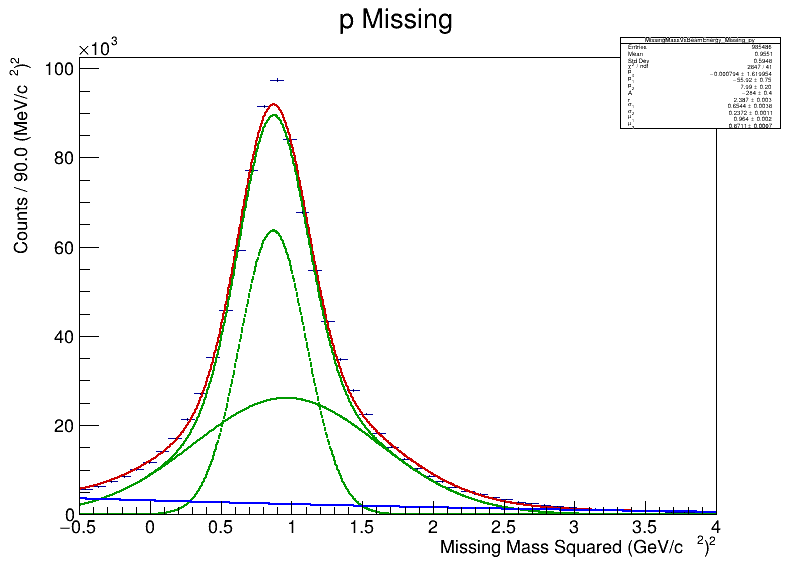

In [7]:
fitResult = fitMissingMassSquared(MM2Hist, forceCommonGaussianMean = False)
ROOT.gStyle.SetOptFit(True)
MM2Hist.Draw()
canv.Draw()

Fit bins in beam energy

In [8]:
def getMissingMassSquaredBeamEnergyBins(MM2vsBeamEnergyHist,
                                        nmbBeamEnergyBins = 9,          # 1 GeV bin width
                                        beamEnergyRange = (3.0, 12.0),  # [GeV]
                                        minCounts = 1000):              # minimum number of counts required in bin
  energyBinWidth = (beamEnergyRange[1] - beamEnergyRange[0]) / float(nmbBeamEnergyBins)
  MM2Hists = {}
  for energyBin in range(nmbBeamEnergyBins):
    # get distribution for given beam energy bin
    energyBinMin = beamEnergyRange[0] + energyBin * energyBinWidth
    energyBinMax = energyBinMin + energyBinWidth
    MM2Hist = MM2vsBeamEnergyHist.ProjectionY(f"{MM2vsBeamEnergyHist.GetName()}_py_{energyBin}",
      MM2vsBeamEnergyHist.GetXaxis().FindBin(energyBinMin),
      MM2vsBeamEnergyHist.GetXaxis().FindBin(energyBinMax))
    MM2Hist.Rebin(35)
    MM2Hist.SetTitle(f"{MM2vsBeamEnergyHist.GetTitle()}, {energyBinMin} < E_{{#gamma}} (GeV) < {energyBinMax}")
    MM2Hist.SetYTitle(f"Counts / {MM2Hist.GetBinWidth(1) * 1000} (MeV/c^{{2}})^{{2}}")
    counts = MM2Hist.Integral(1, MM2Hist.GetNbinsX())
    if  counts >= minCounts:
      MM2Hists[(energyBinMin, energyBinMax)] = MM2Hist
    else:
      print(f"Warning: {counts} counts in energy bin {(energyBinMin, energyBinMax)} are below the required minimum of {minCounts}. Skipping bin.")

  return MM2Hists

In [9]:
MM2Hists = getMissingMassSquaredBeamEnergyBins(MM2vsBeamEnergyHist, 72)

In [10]:
def fitMissingMassSquaredBeamEnergyBins(MM2Hists):  # dictionary {energy bin : histogram}
  fitResults = {}
  for energyBin, MM2Hist in MM2Hists.items():
    # fit distribution
    print(f"Fitting beam energy bin {energyBin}")
    fitResults[energyBin] = fitMissingMassSquared(MM2Hist)

  return fitResults

In [11]:
fitResults = fitMissingMassSquaredBeamEnergyBins(MM2Hists)

Fitting beam energy bin (3.0, 3.125)
reduced chi^2 = 2.6650304222470065; P-value = 0.0001520878944588548
Fitting beam energy bin (3.125, 3.25)
reduced chi^2 = 1.8900581407198604; P-value = 0.016792309066830293
Fitting beam energy bin (3.25, 3.375)
reduced chi^2 = 2.357212318649138; P-value = 0.0005601471072133012
Fitting beam energy bin (3.375, 3.5)
reduced chi^2 = 2.1779632726075975; P-value = 0.003338618261188828
Fitting beam energy bin (3.5, 3.625)
reduced chi^2 = 2.070047880103159; P-value = 0.004845345381924971
Fitting beam energy bin (3.625, 3.75)
reduced chi^2 = 2.2001022239183645; P-value = 0.002967673685309837
Fitting beam energy bin (3.75, 3.875)
reduced chi^2 = 14.219388376268736; P-value = 6.108779428686811e-51
Fitting beam energy bin (3.875, 4.0)
reduced chi^2 = 11.722325656432748; P-value = 3.790561517927424e-42
Fitting beam energy bin (4.0, 4.125)
reduced chi^2 = 1.1534265695688215; P-value = 0.27654307511843484
Fitting beam energy bin (4.125, 4.25)
reduced chi^2 = 1.326

Warning in <Fit>: Abnormal termination of minimization.
Warning in <Fit>: Abnormal termination of minimization.


In [12]:
COV_MATRIX_STATUS_CODE = {
  0 : "not calculated",
  1 : "approximated",
  2 : "made positive definite",
  3 : "accurate"
}
for energyBin, fitResult in fitResults.items():
  print(
    f"energy bin {energyBin}: "
    f"minimizer status = {fitResult.Status()}, "
    f"fit result is valid = {fitResult.IsValid()}, "
    f"covariance matrix status = {COV_MATRIX_STATUS_CODE[fitResult.CovMatrixStatus()]}"
  )

energy bin (3.0, 3.125): minimizer status = 0, fit result is valid = True, covariance matrix status = accurate
energy bin (3.125, 3.25): minimizer status = 4000, fit result is valid = True, covariance matrix status = accurate
energy bin (3.25, 3.375): minimizer status = 4000, fit result is valid = True, covariance matrix status = accurate
energy bin (3.375, 3.5): minimizer status = 4000, fit result is valid = True, covariance matrix status = accurate
energy bin (3.5, 3.625): minimizer status = 4000, fit result is valid = True, covariance matrix status = accurate
energy bin (3.625, 3.75): minimizer status = 4000, fit result is valid = True, covariance matrix status = accurate
energy bin (3.75, 3.875): minimizer status = 4350, fit result is valid = True, covariance matrix status = accurate
energy bin (3.875, 4.0): minimizer status = 4280, fit result is valid = True, covariance matrix status = accurate
energy bin (4.0, 4.125): minimizer status = 0, fit result is valid = True, covariance m

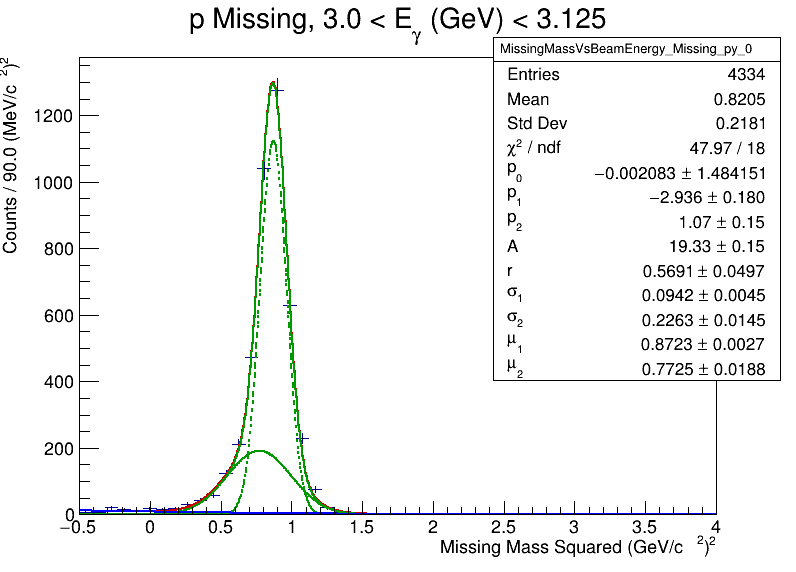

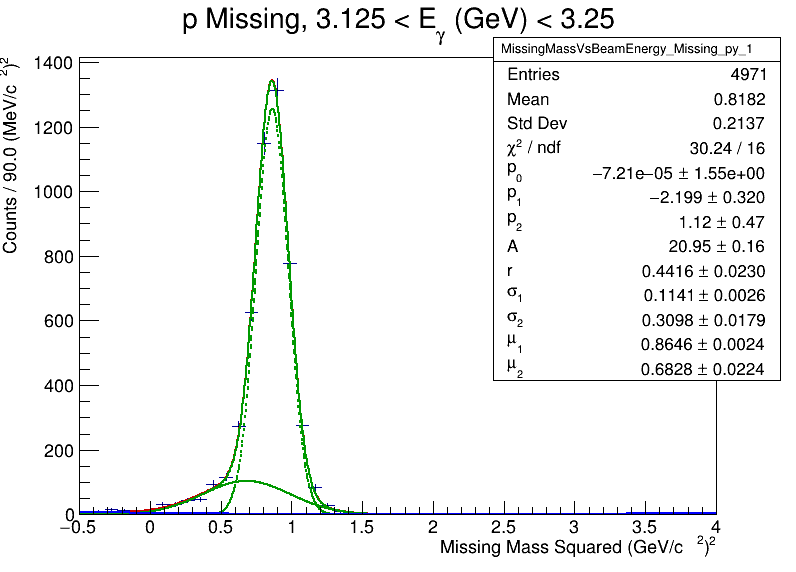

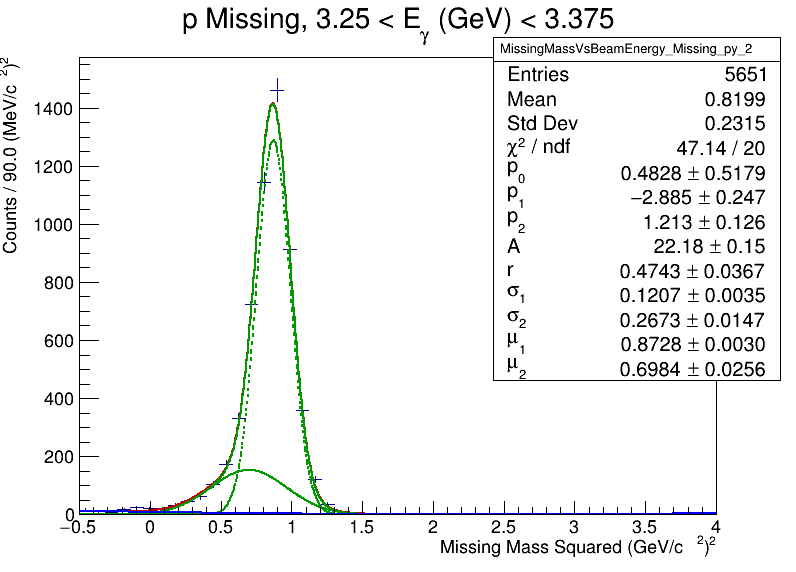

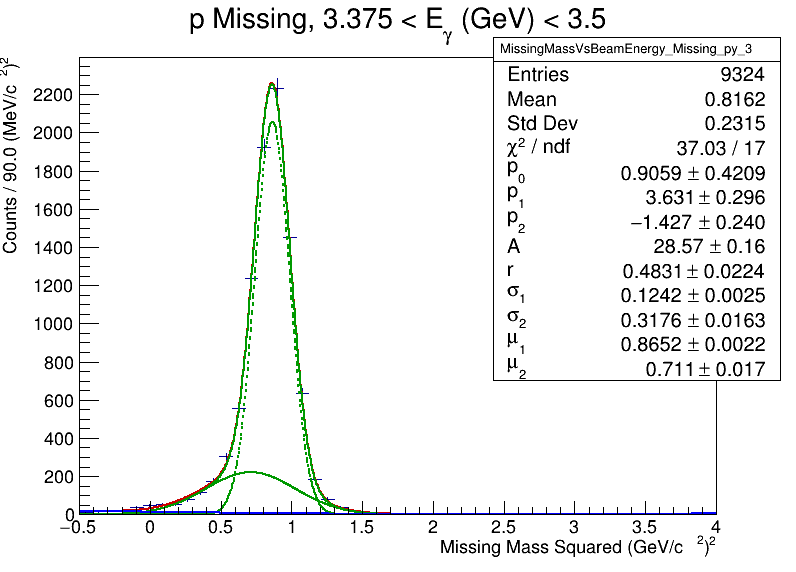

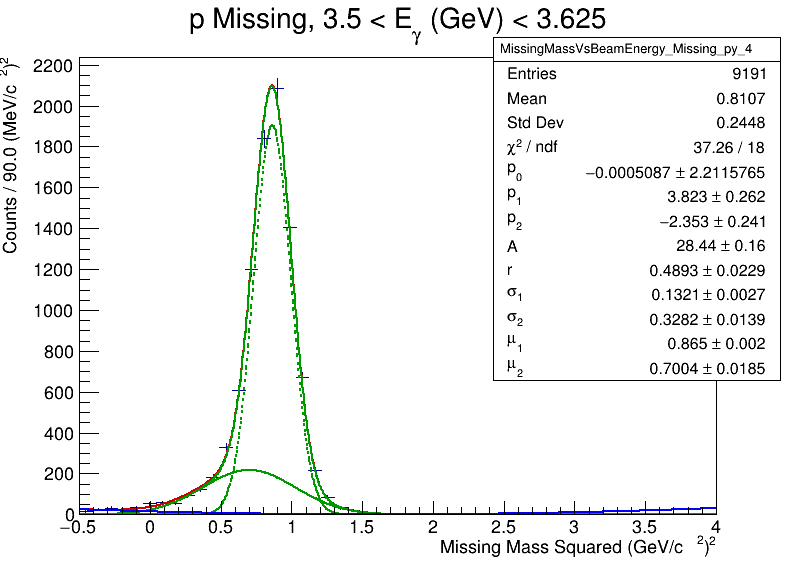

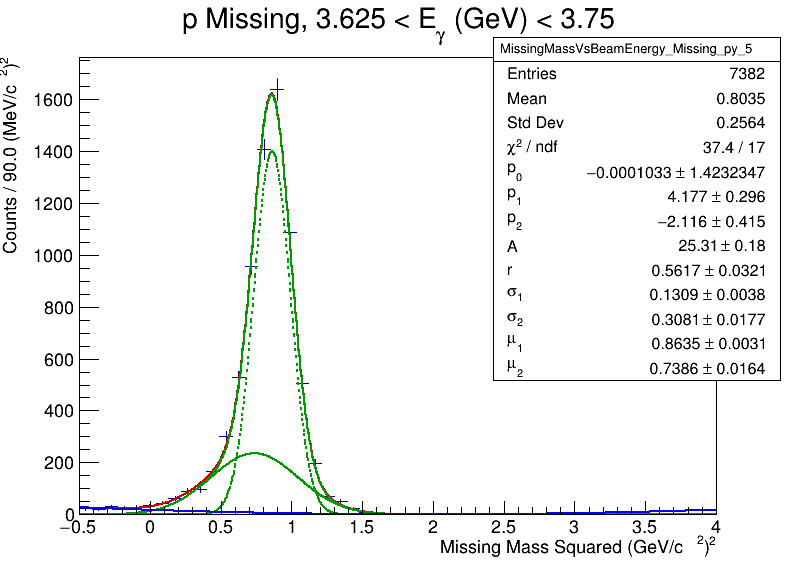

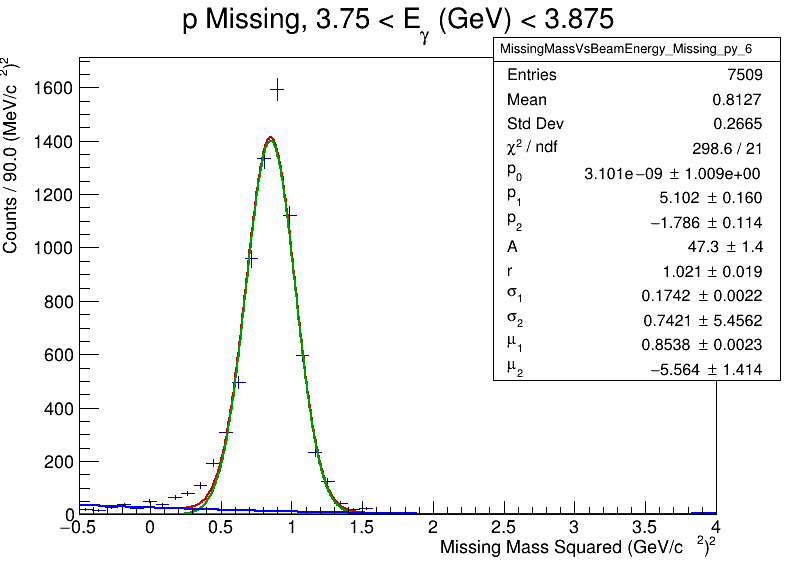

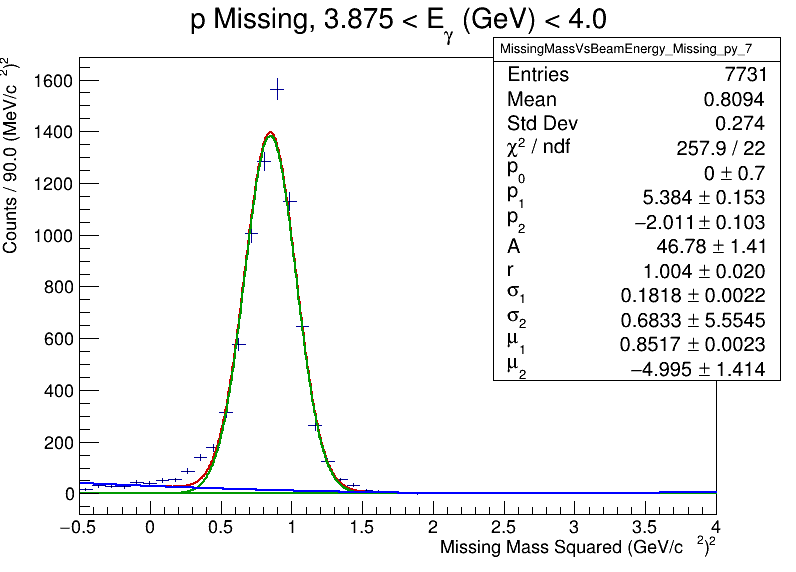

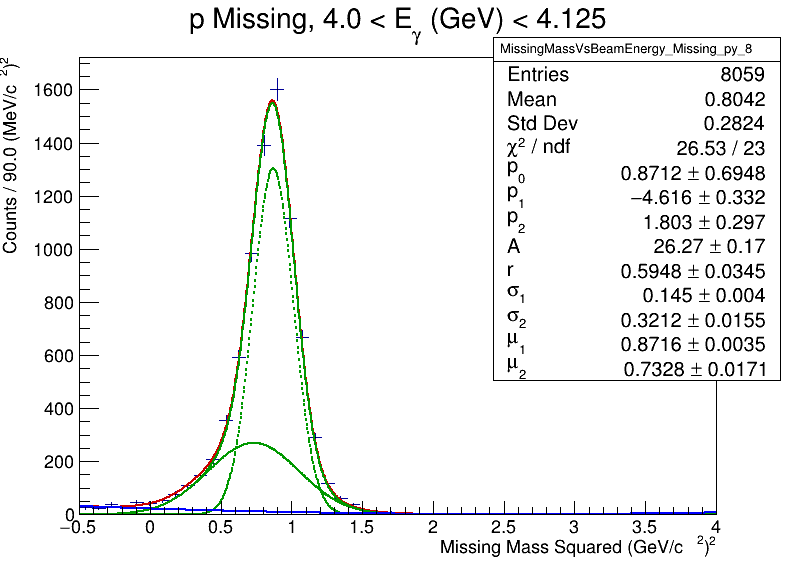

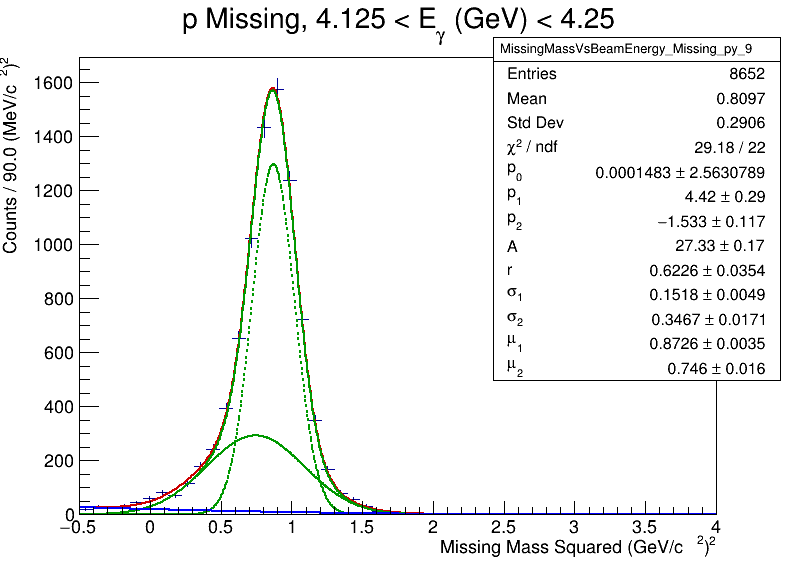

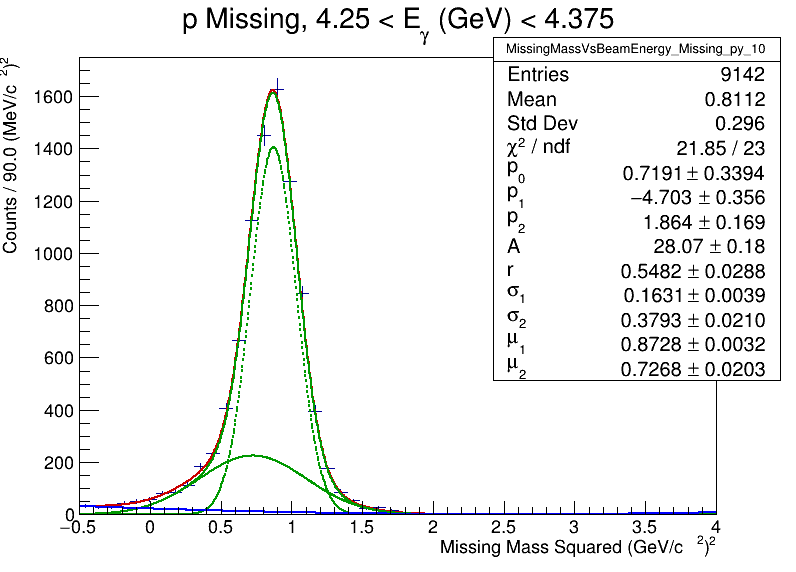

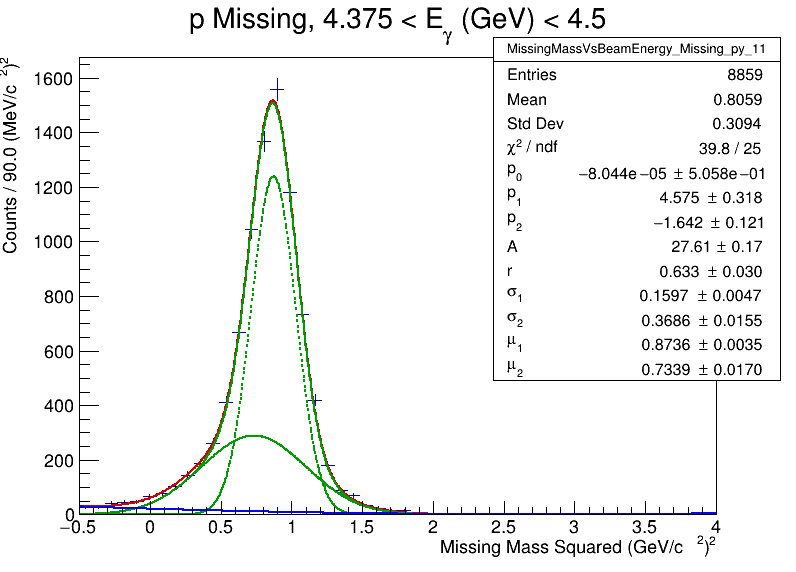

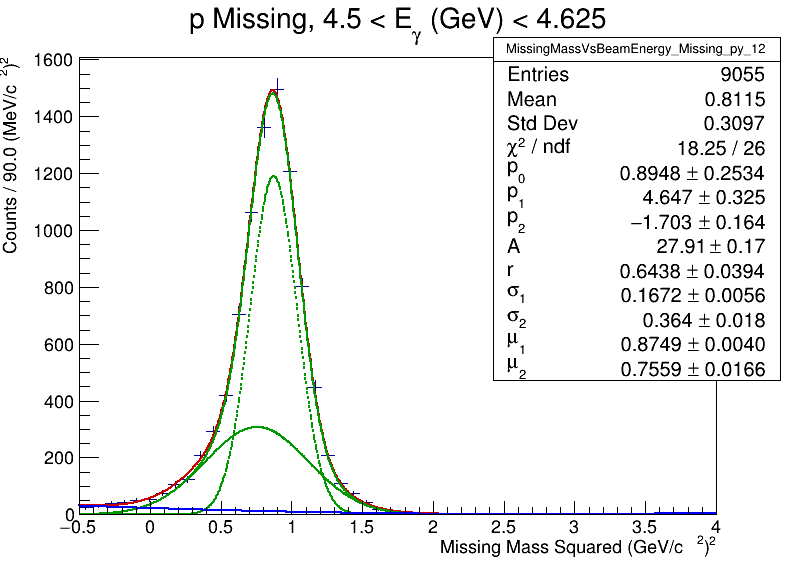

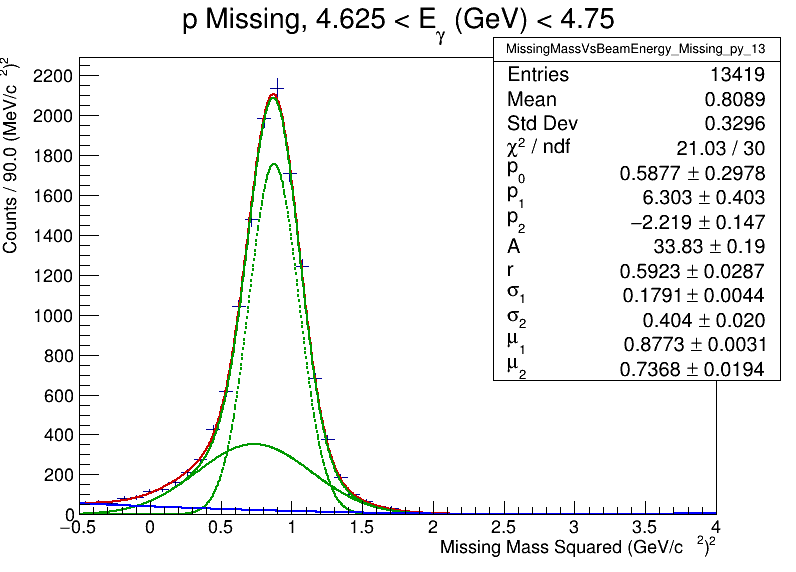

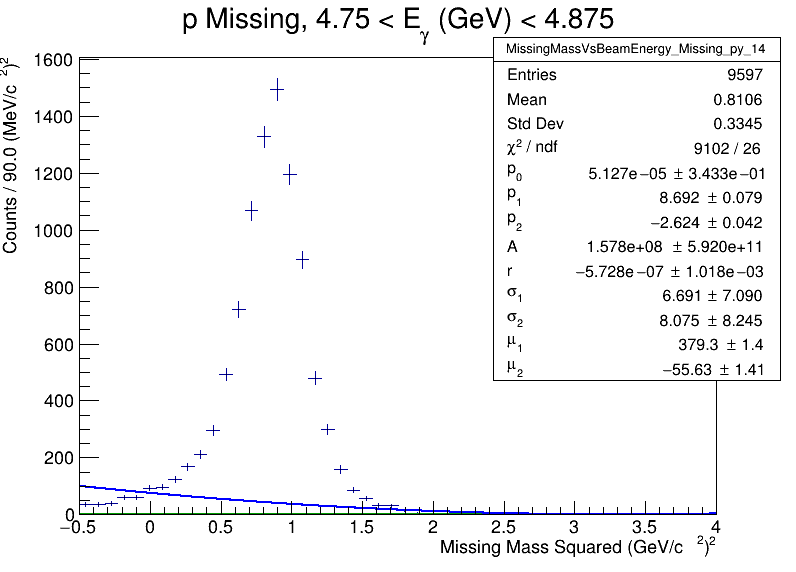

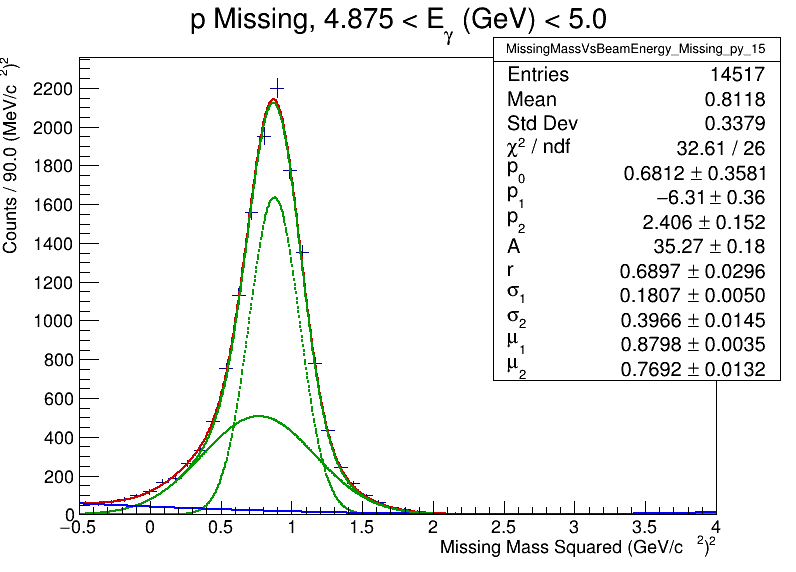

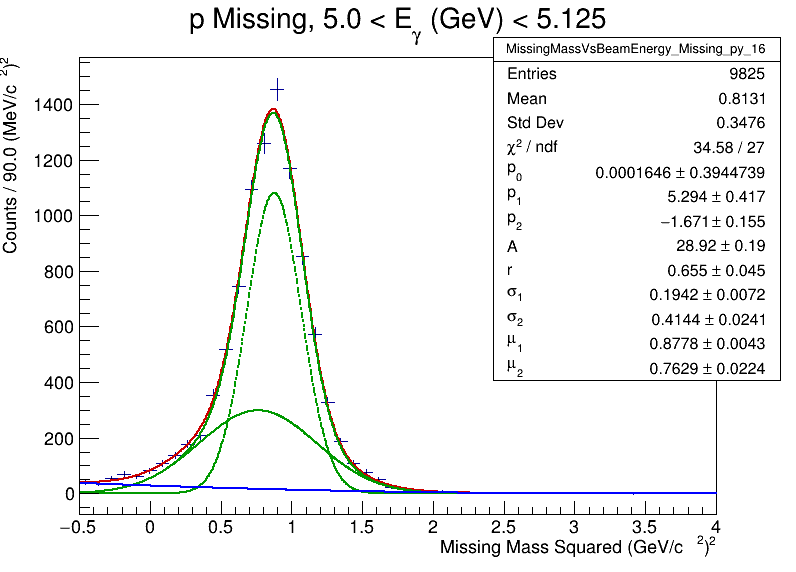

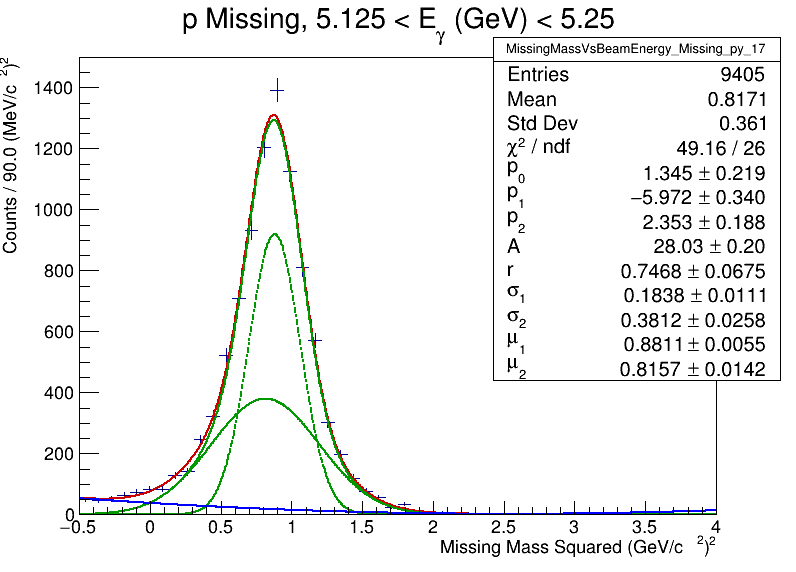

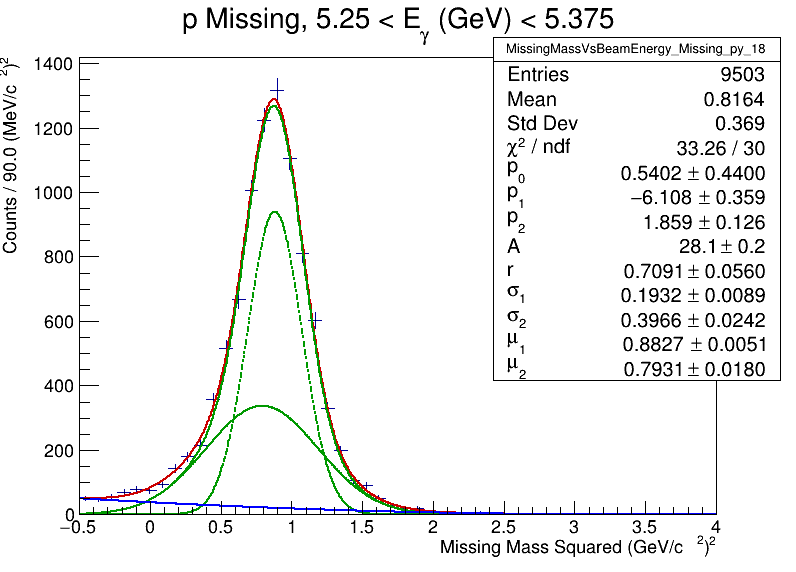

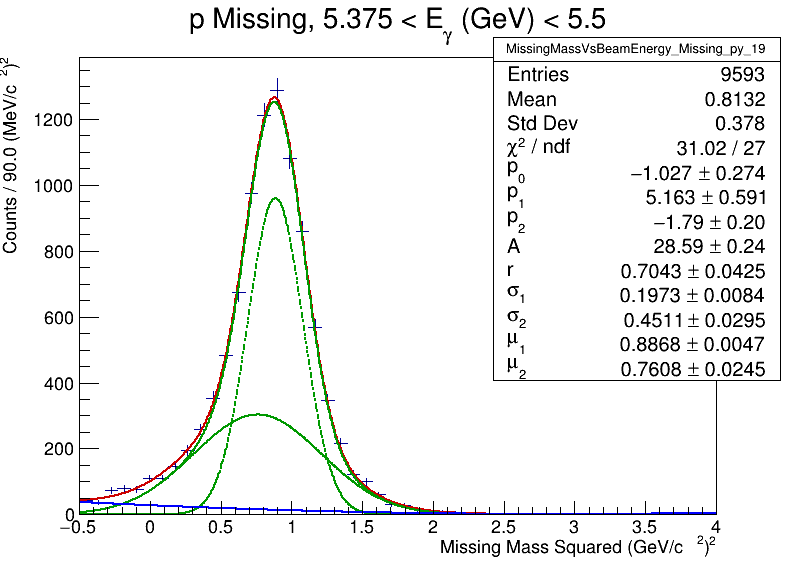

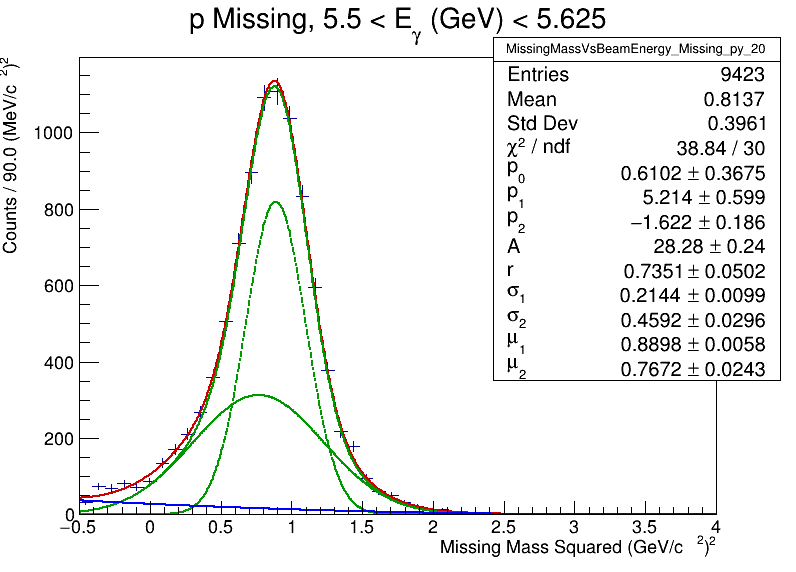

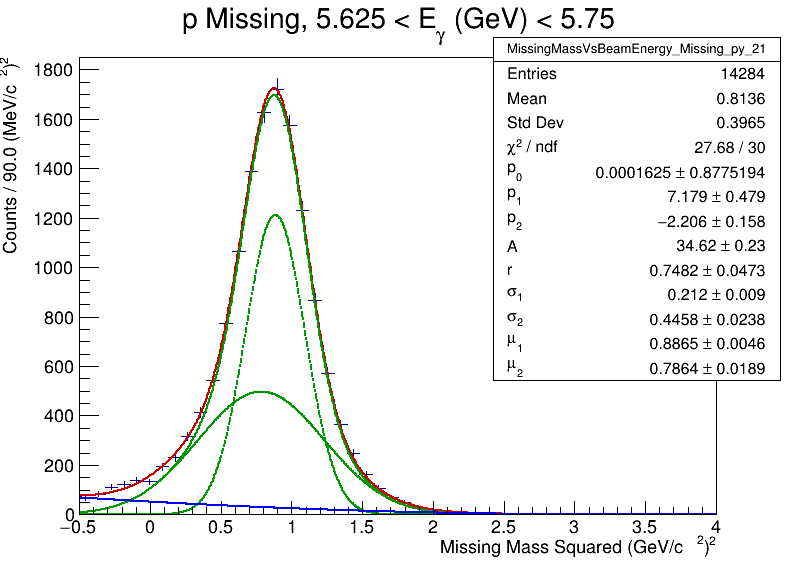

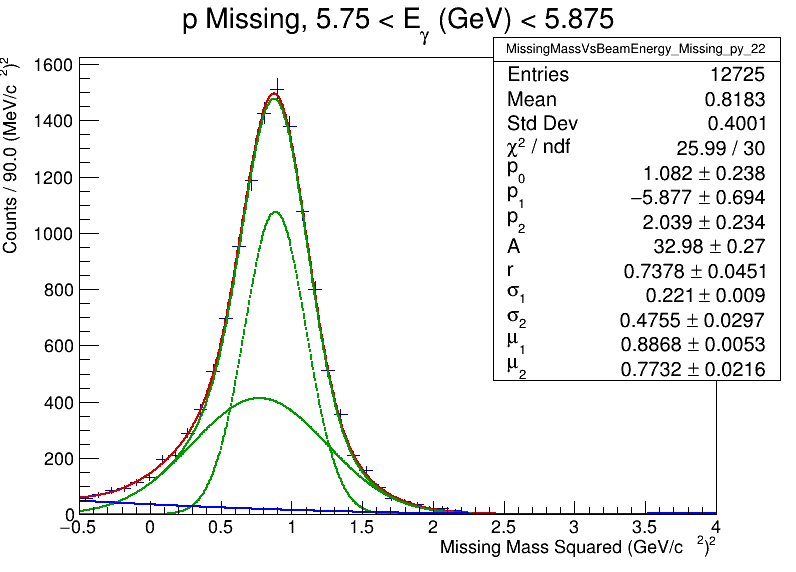

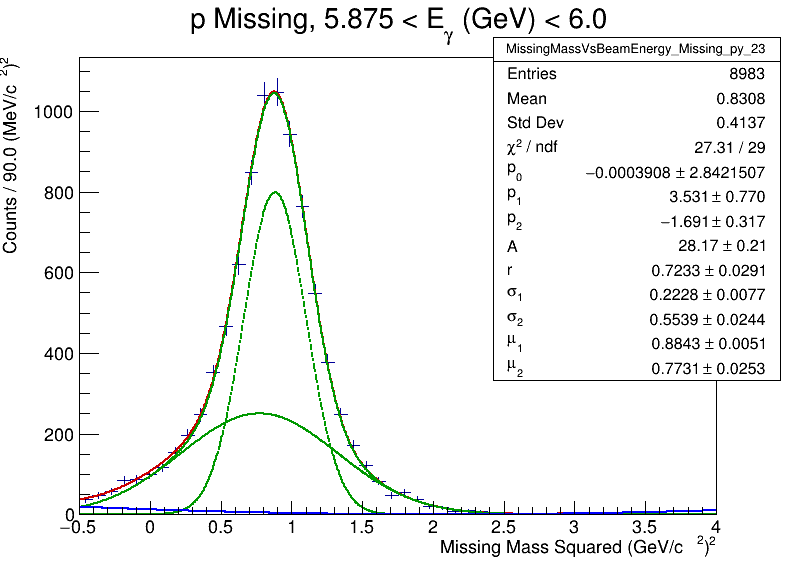

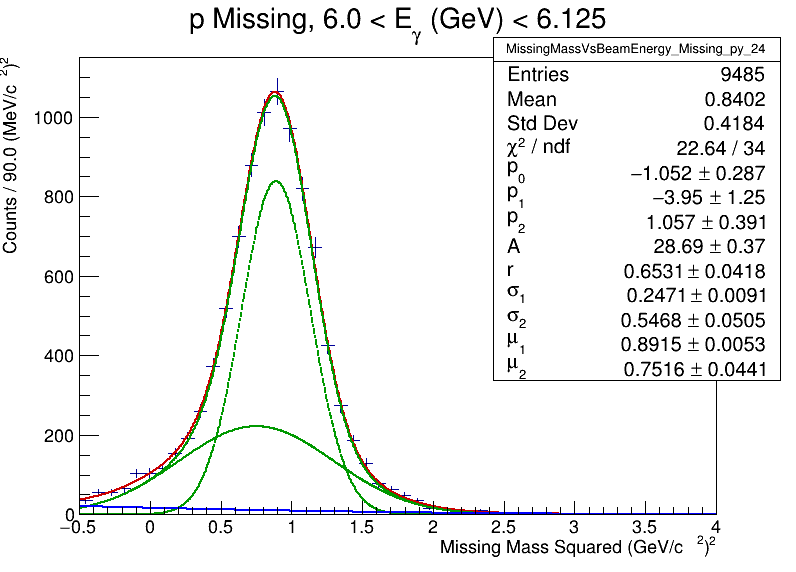

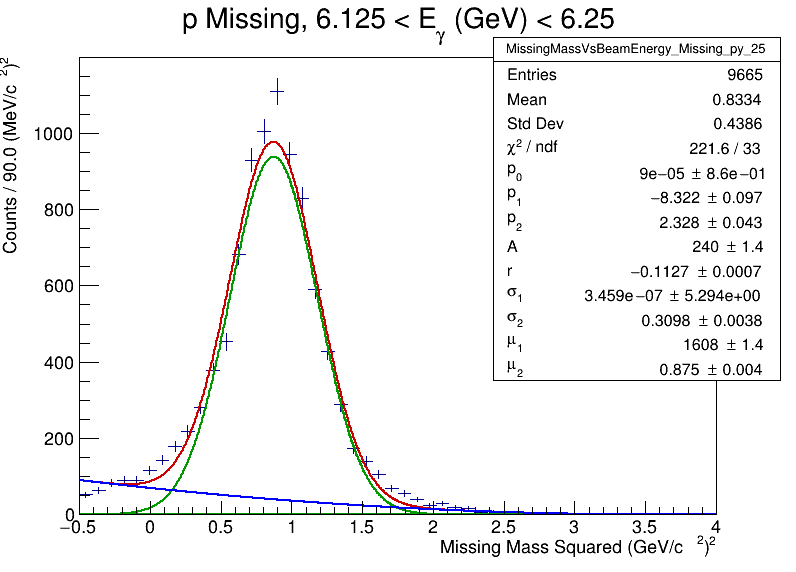

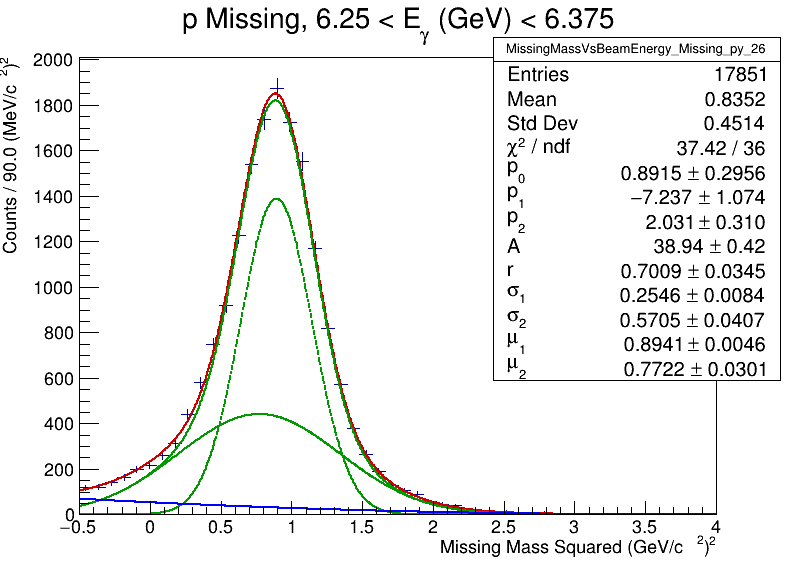

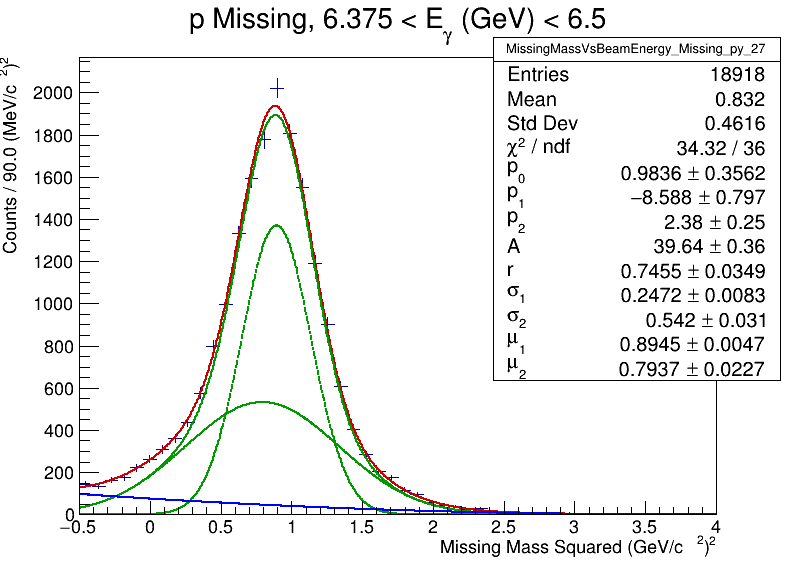

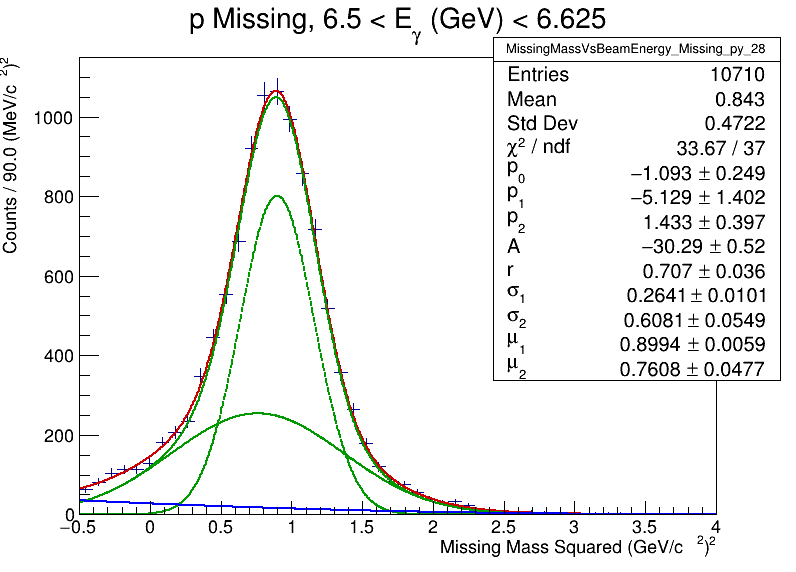

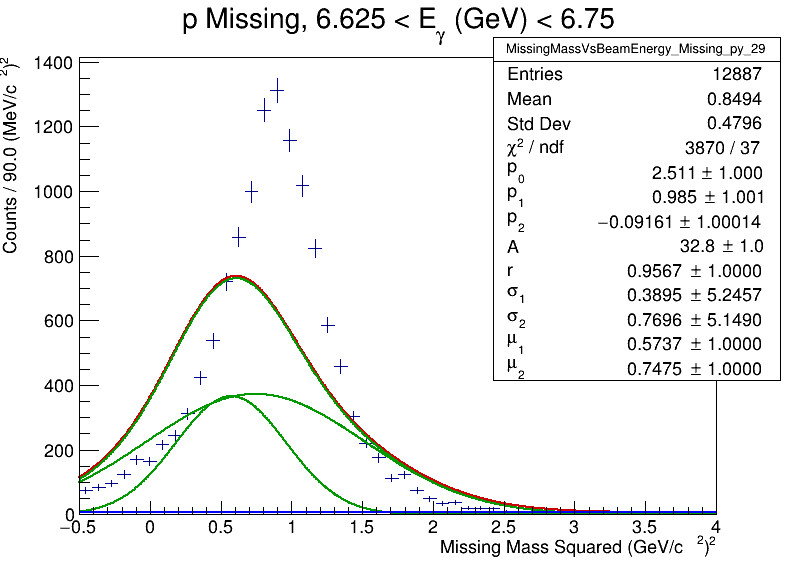

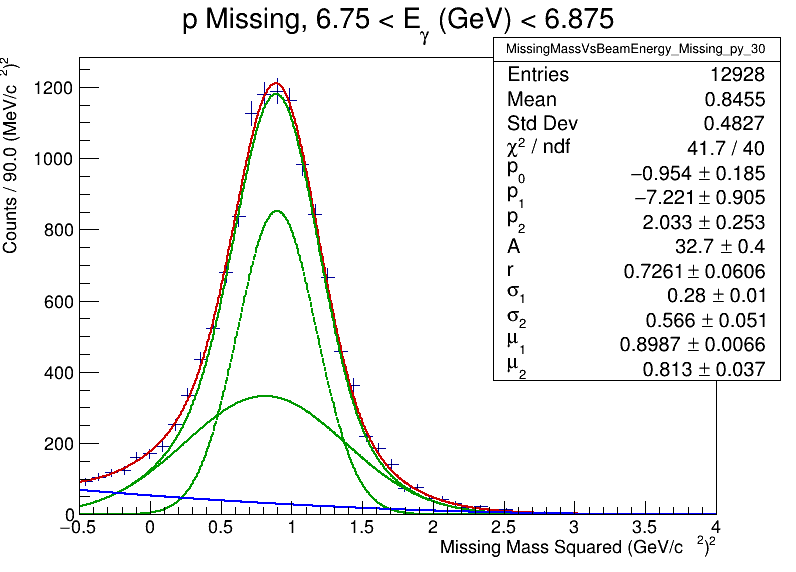

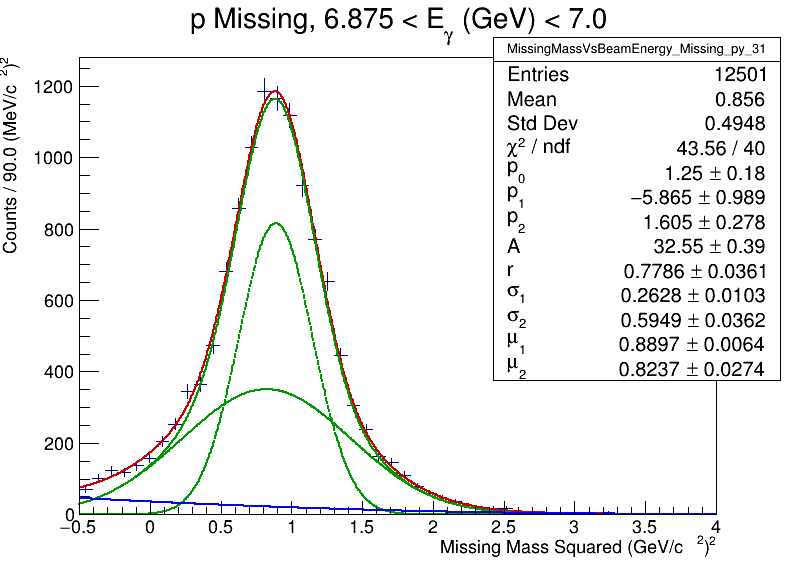

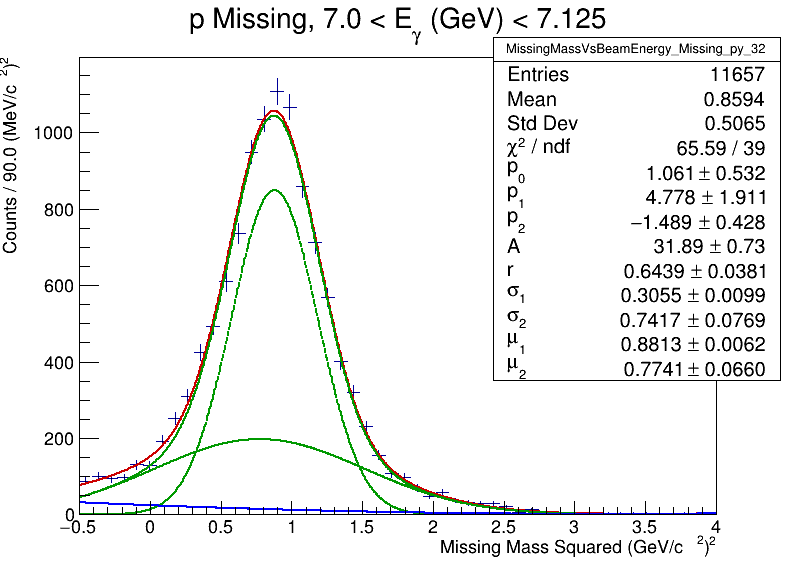

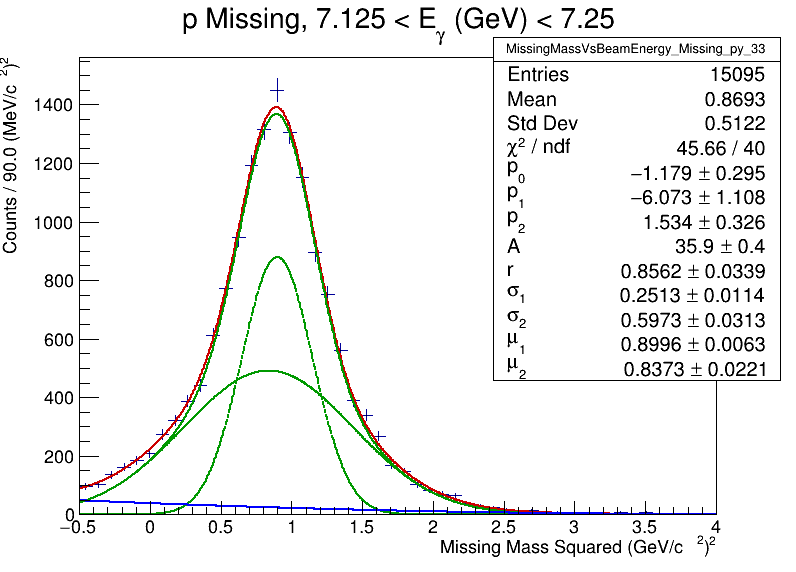

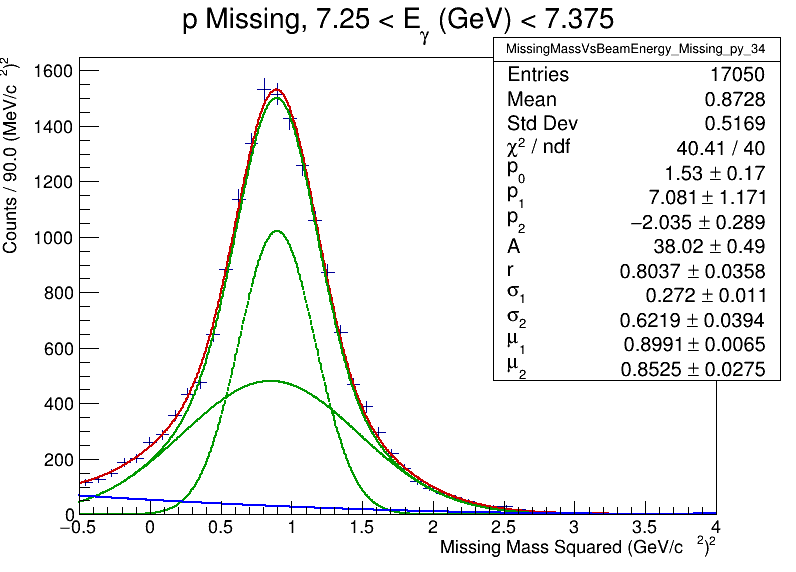

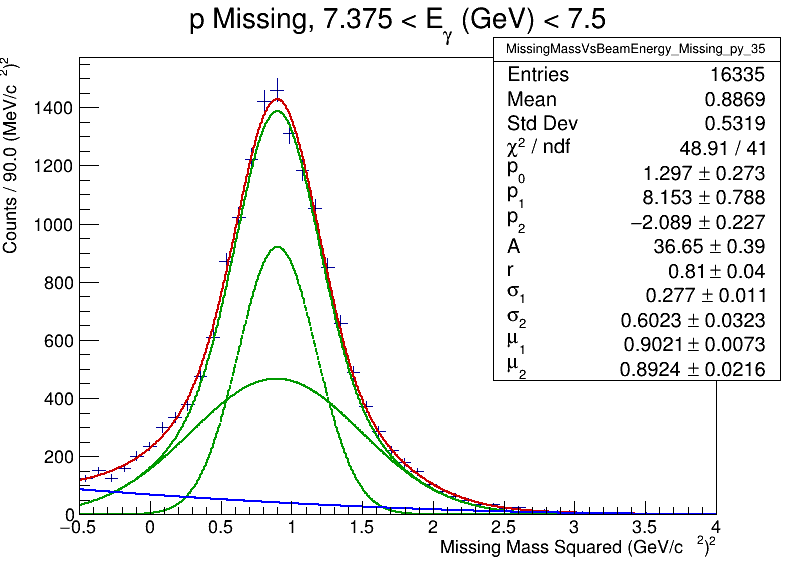

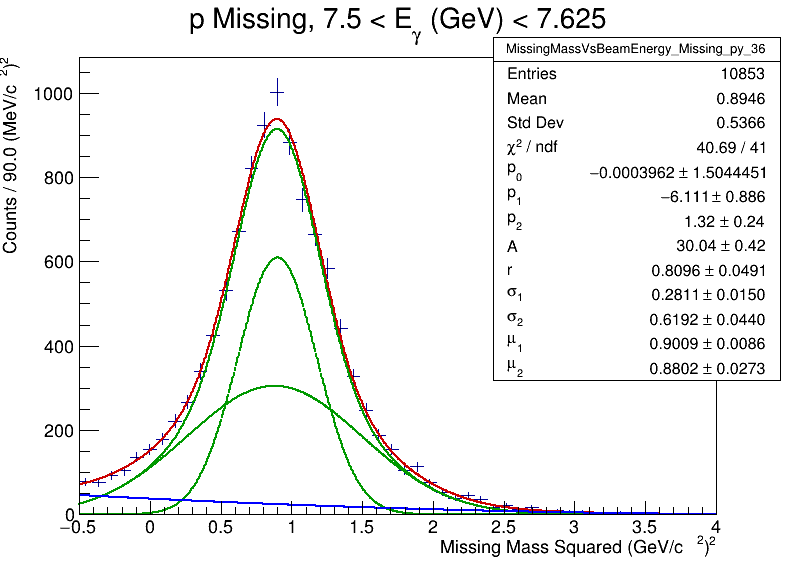

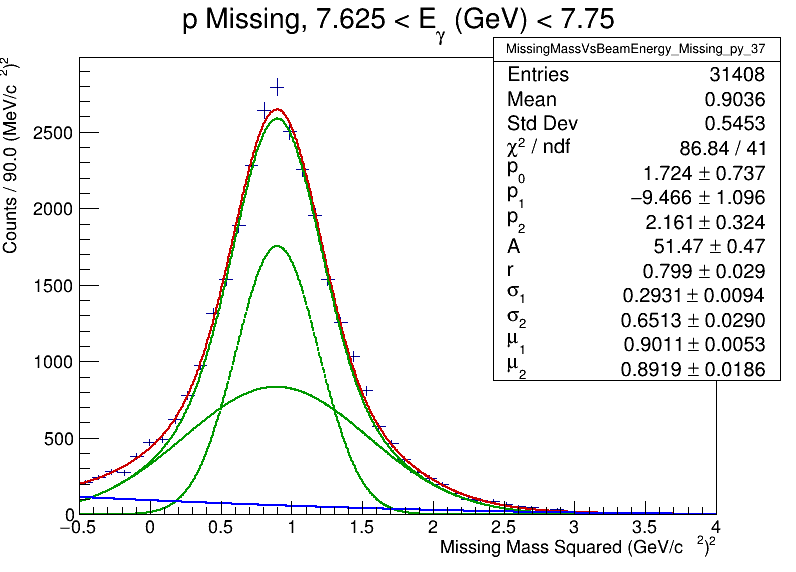

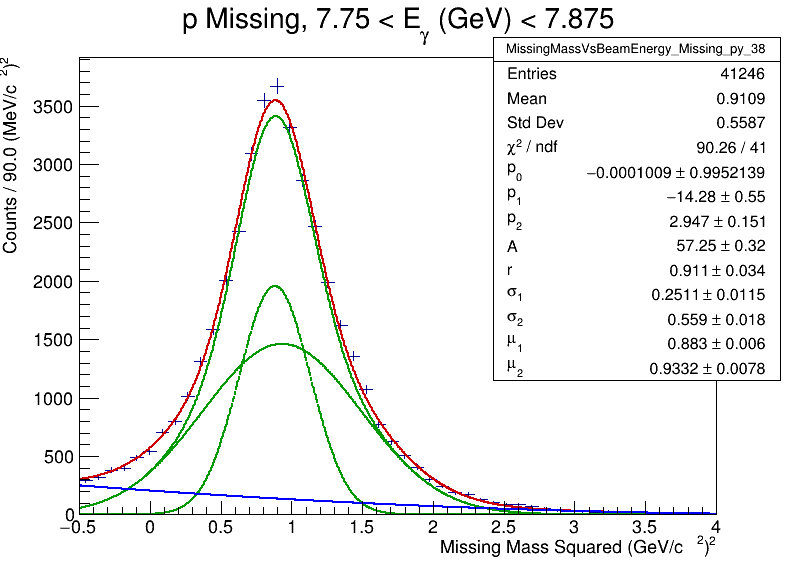

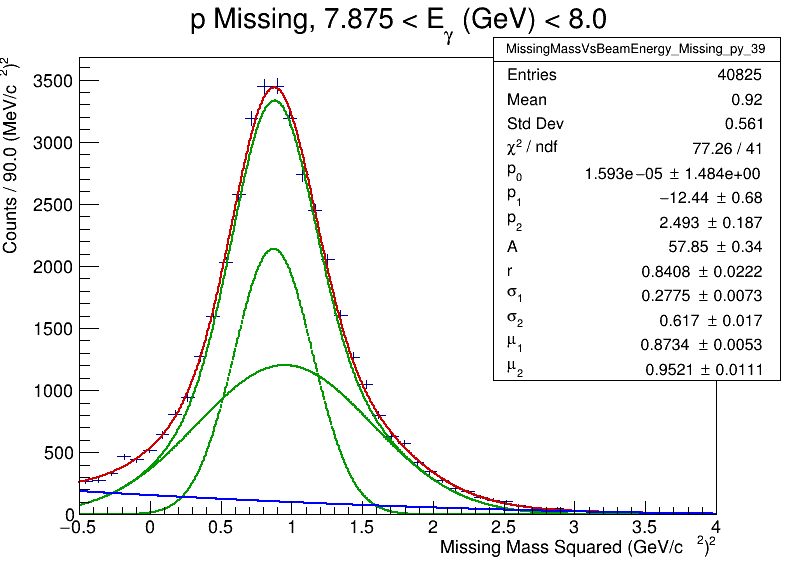

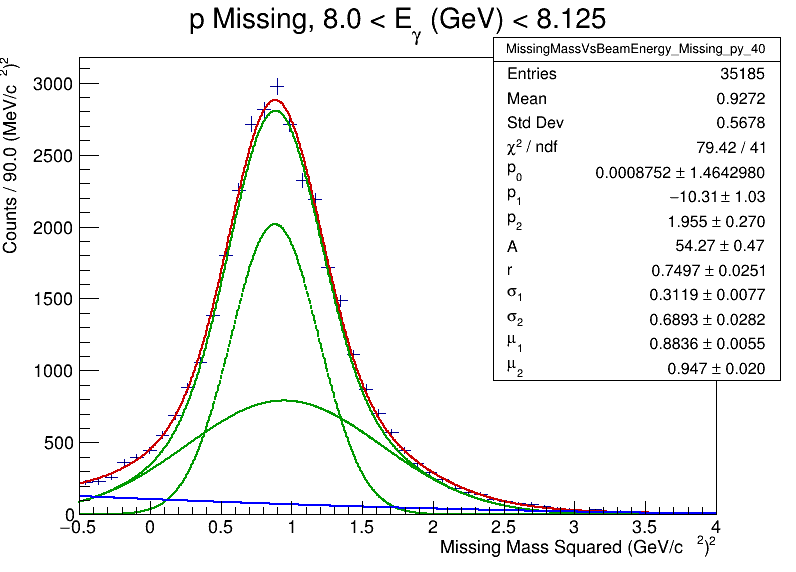

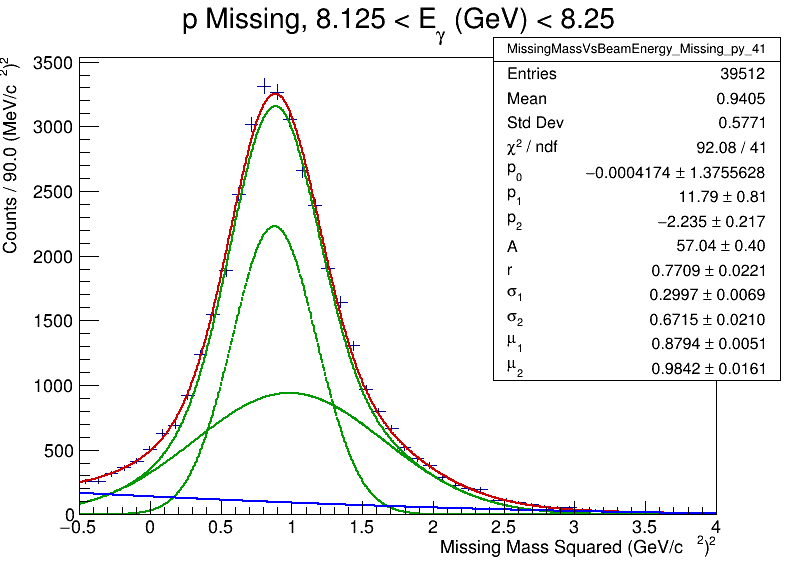

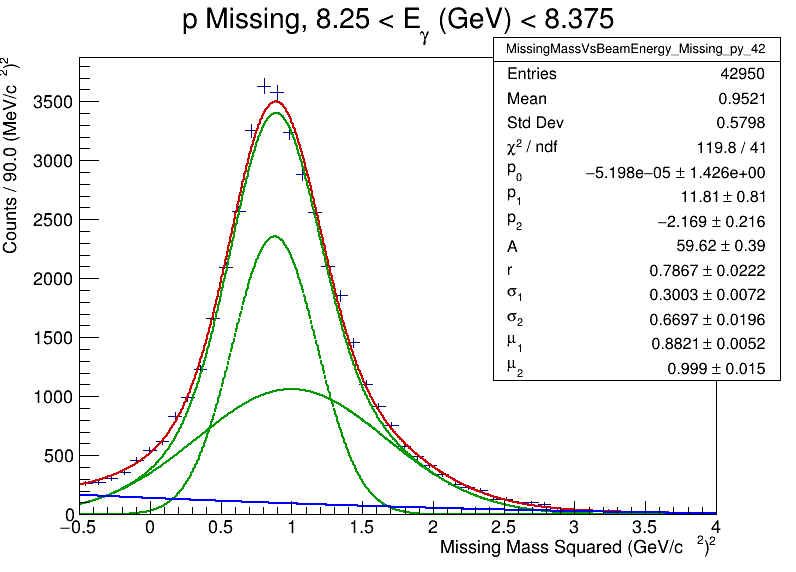

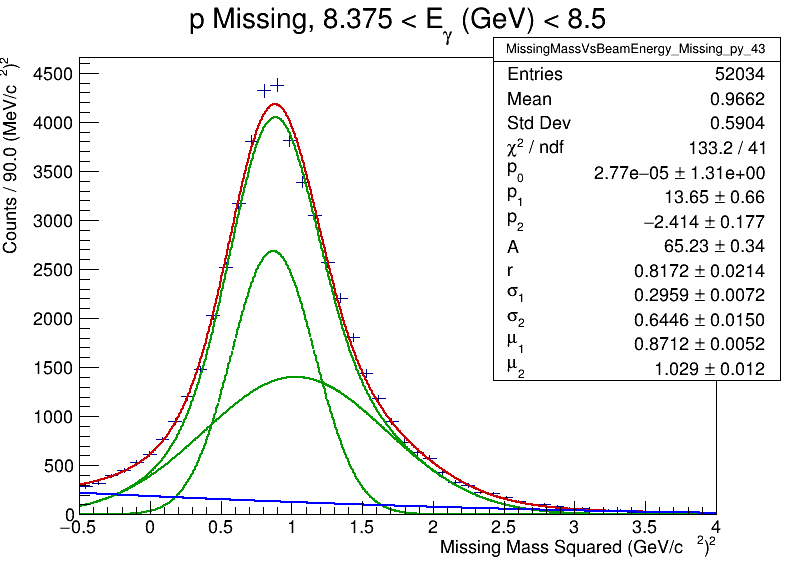

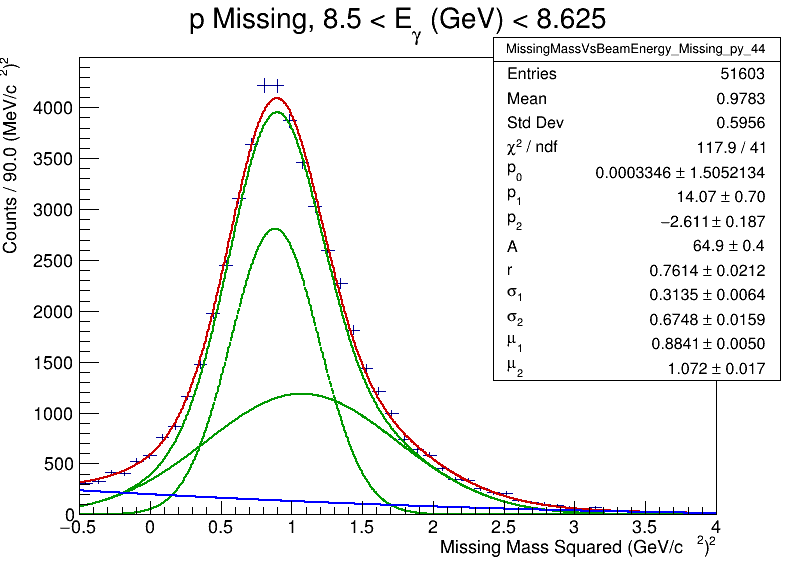

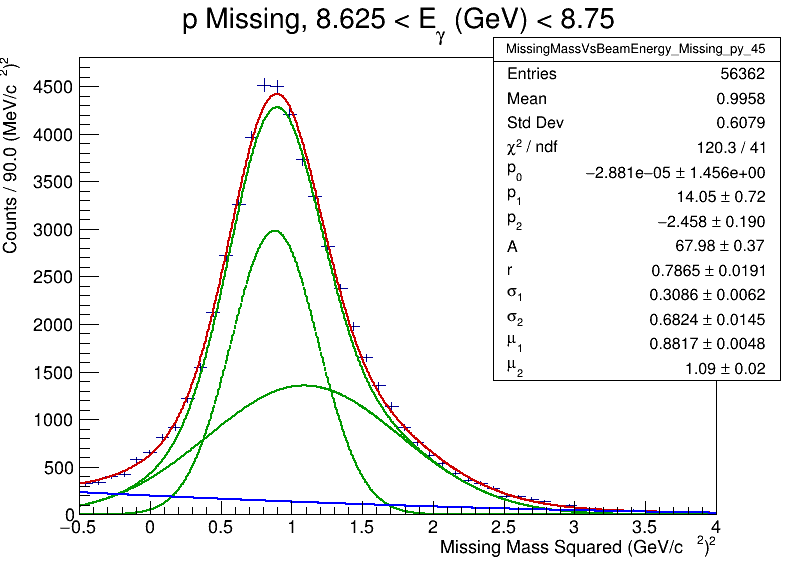

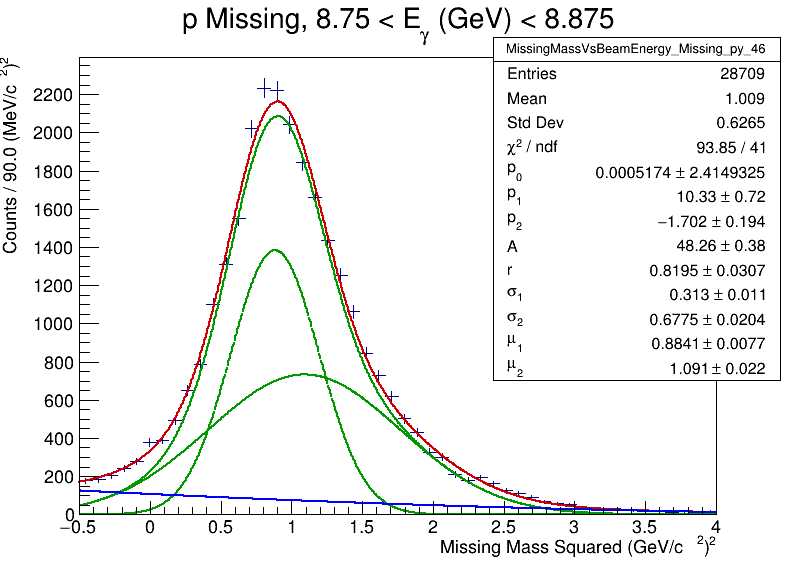

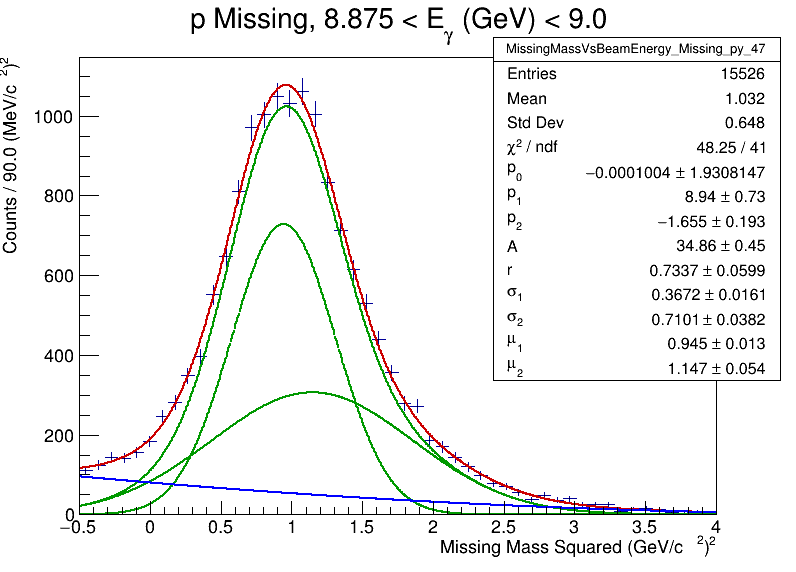

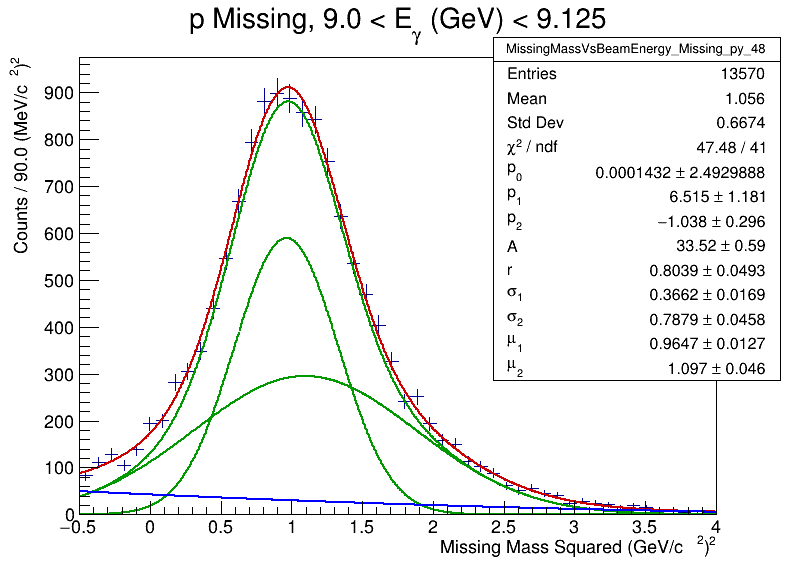

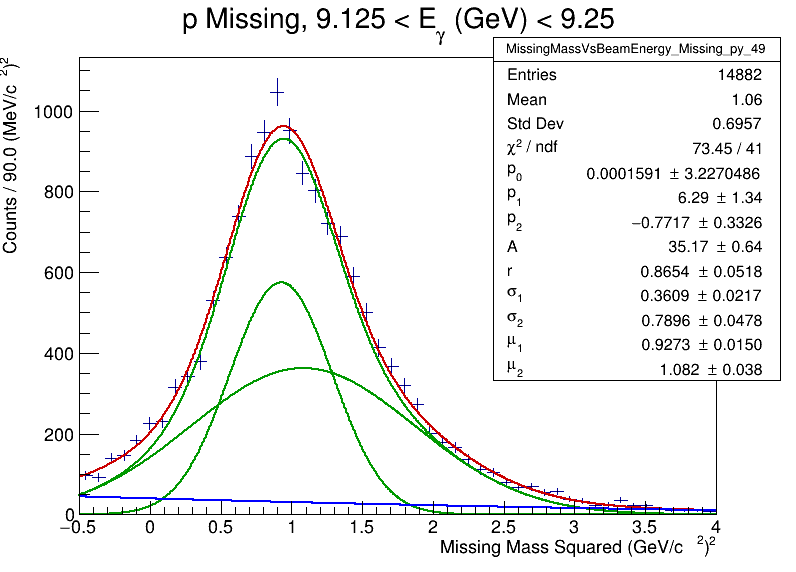

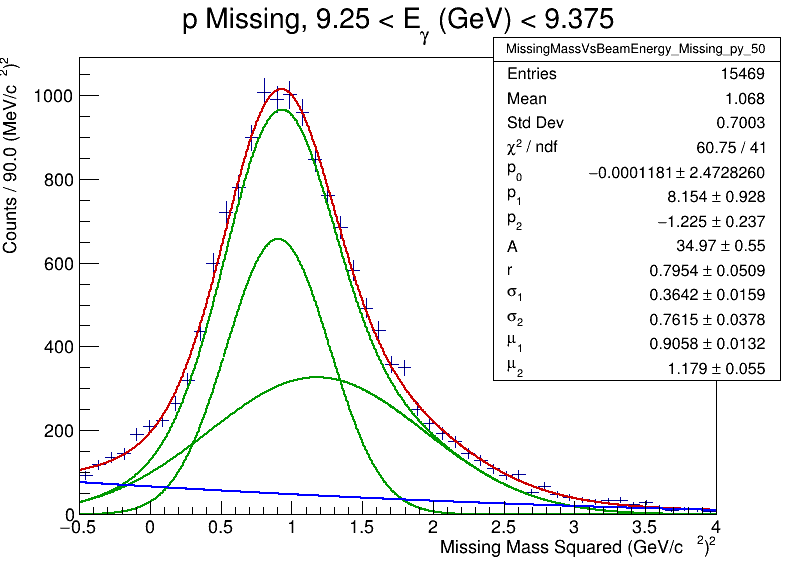

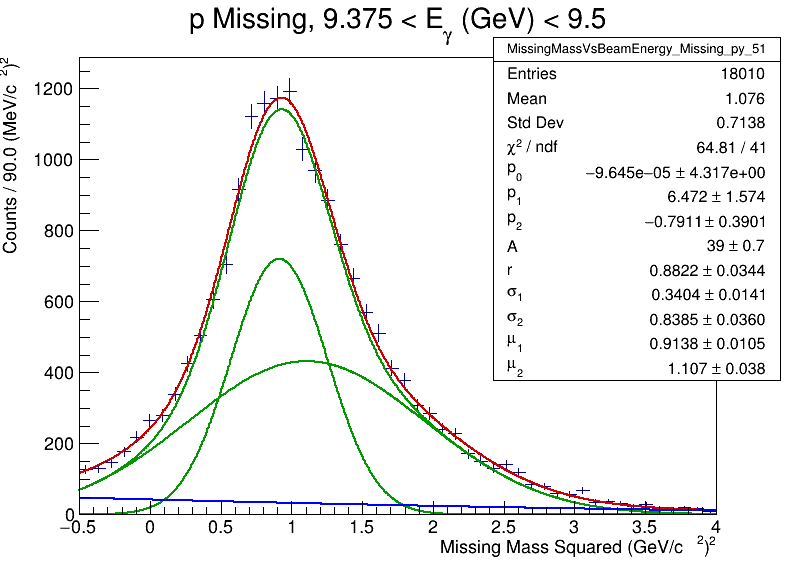

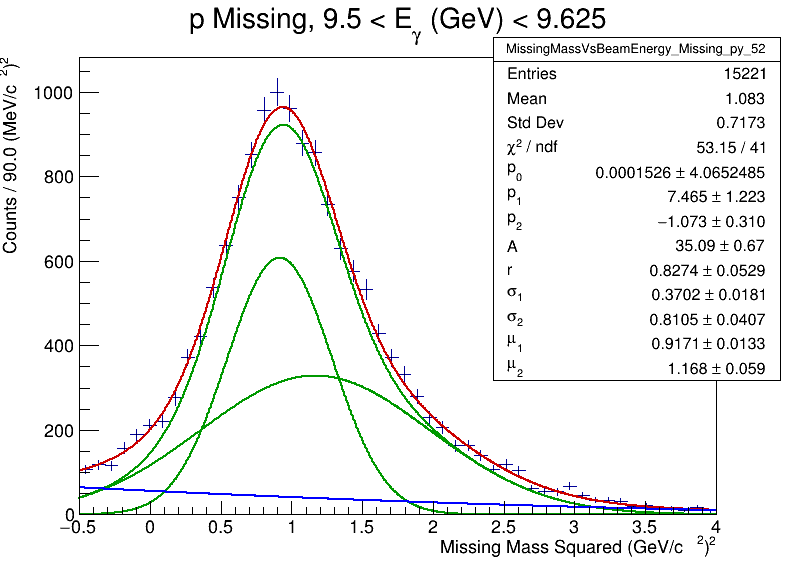

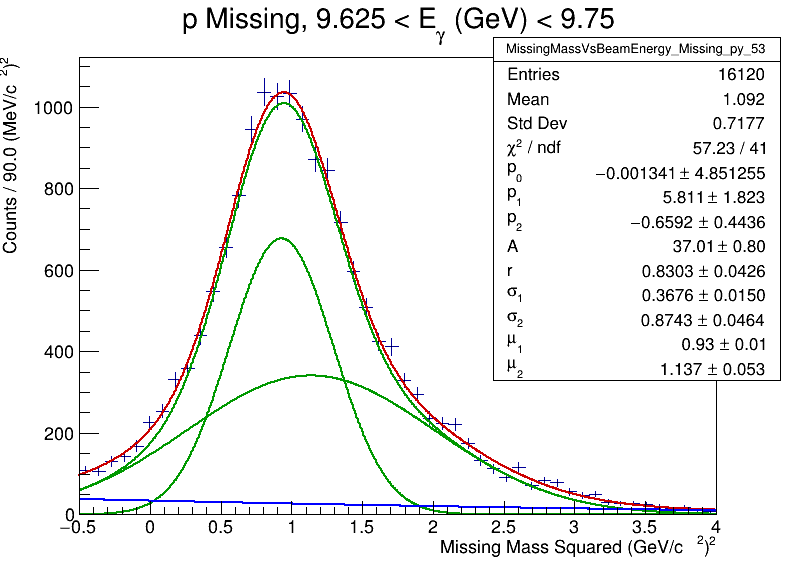

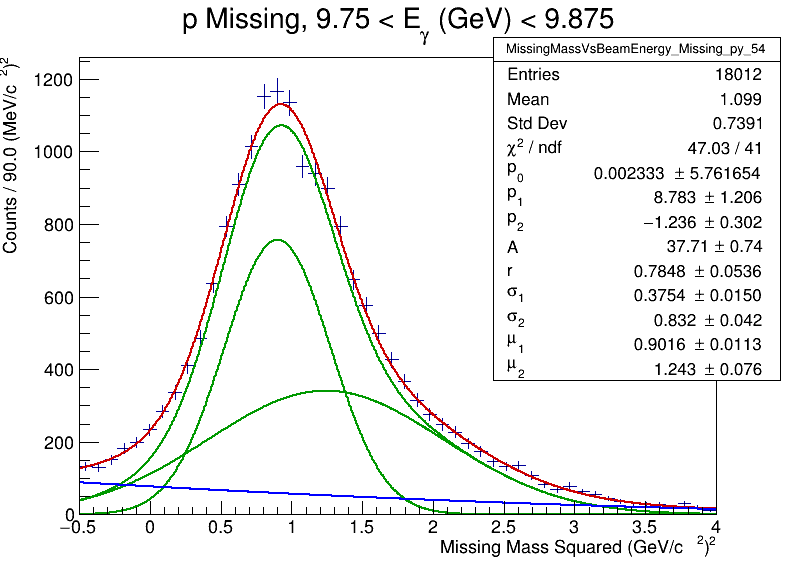

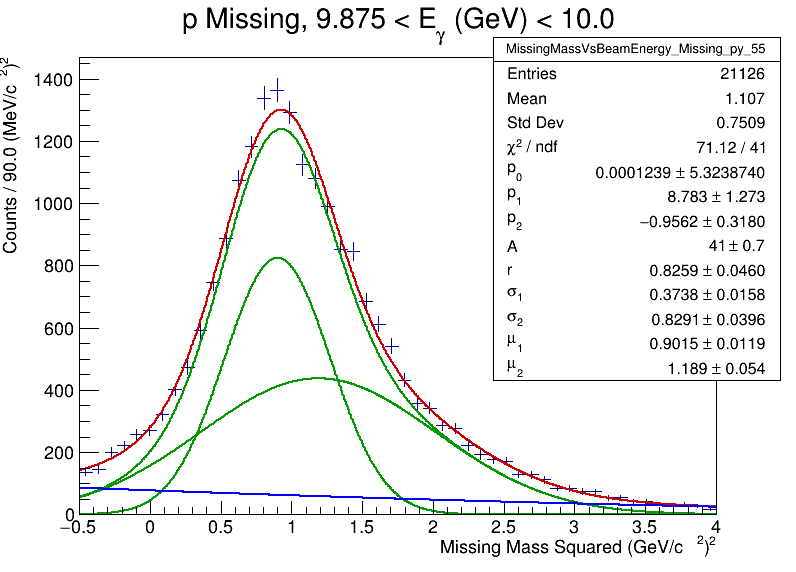

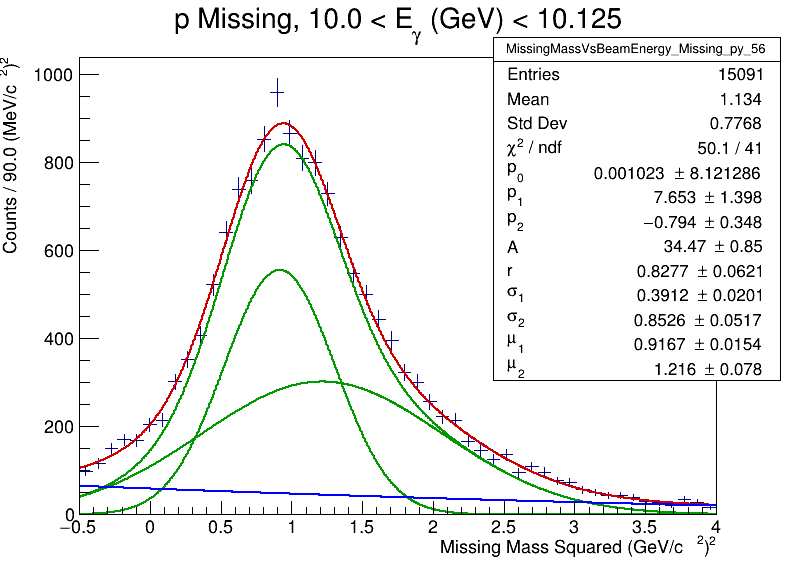

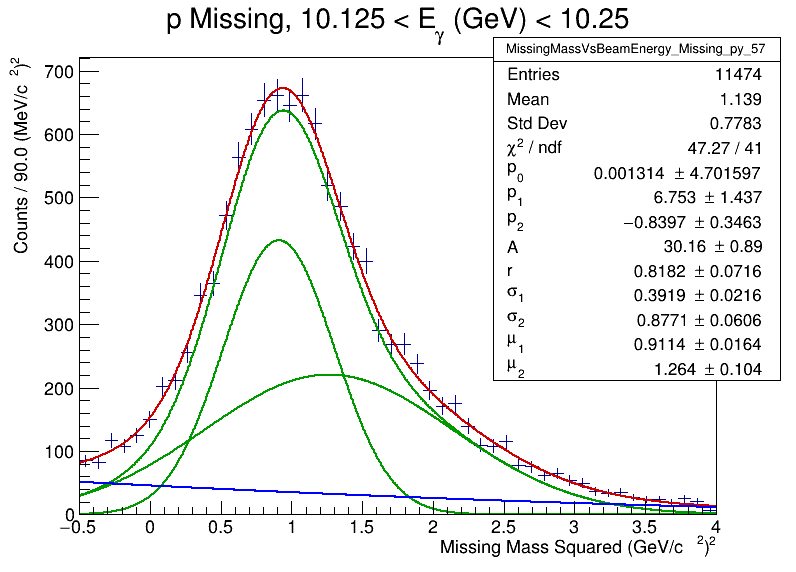

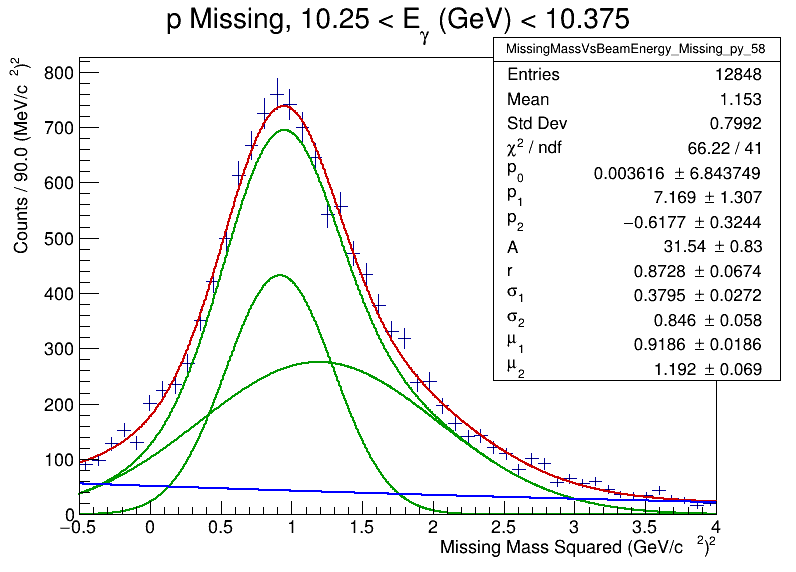

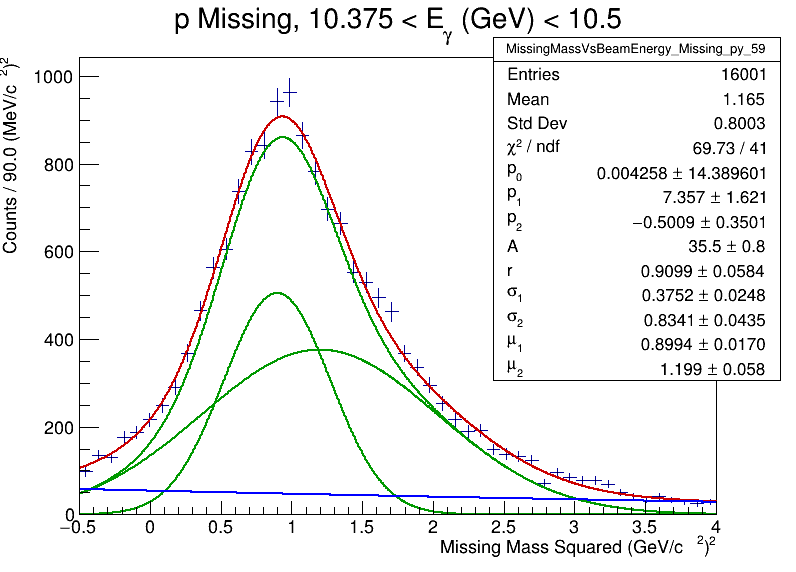

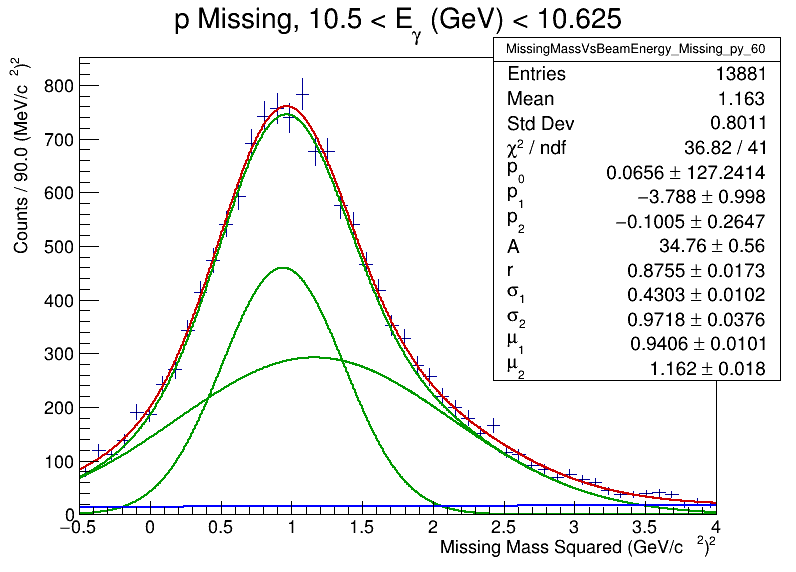

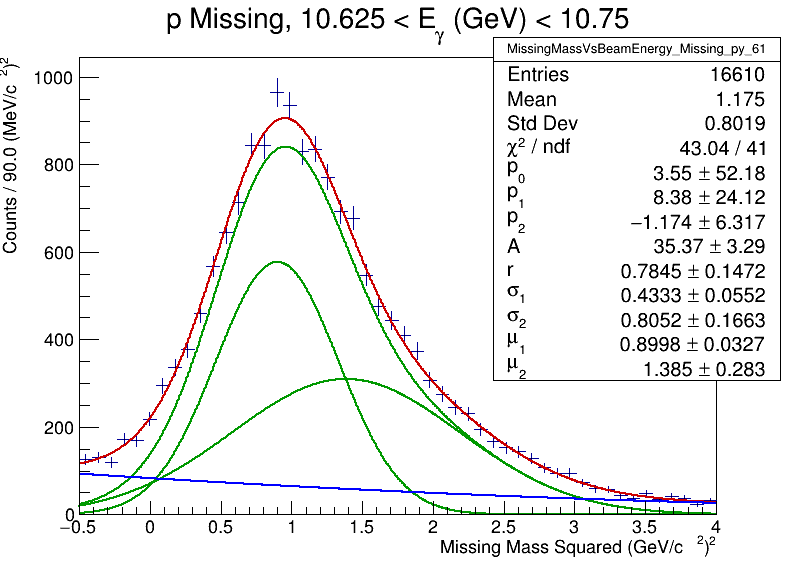

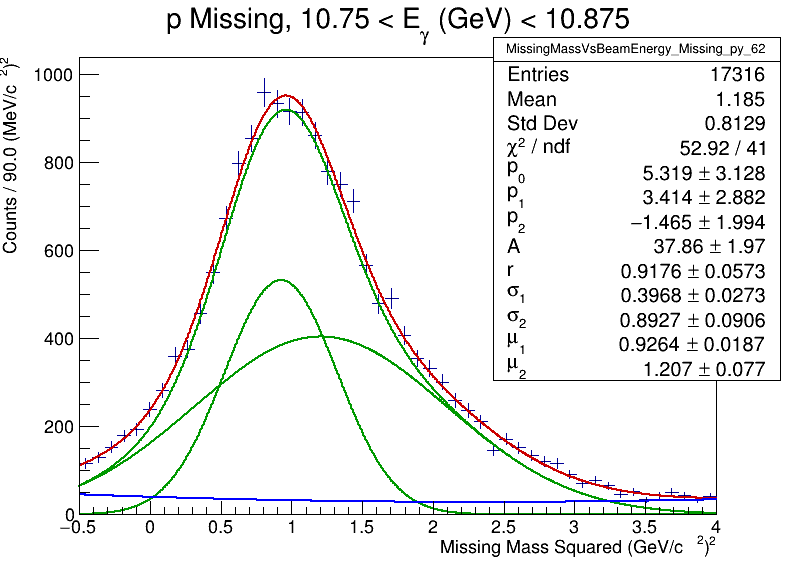

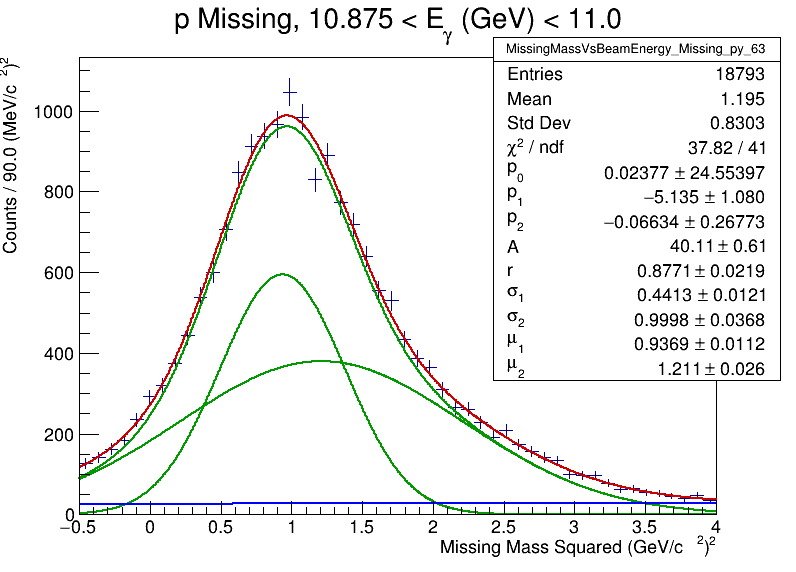

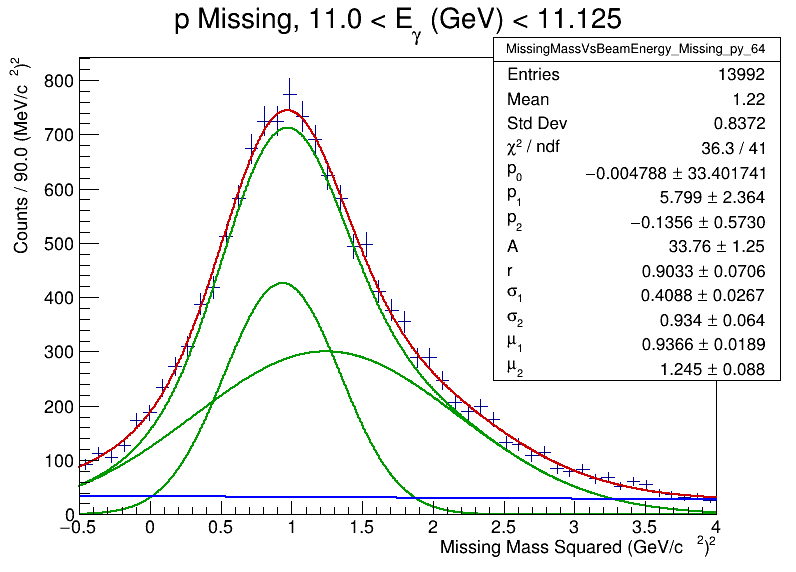

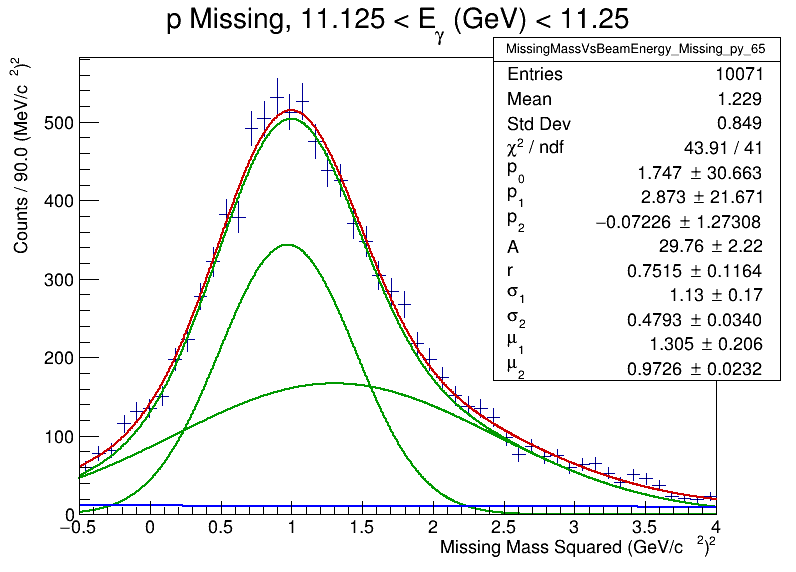

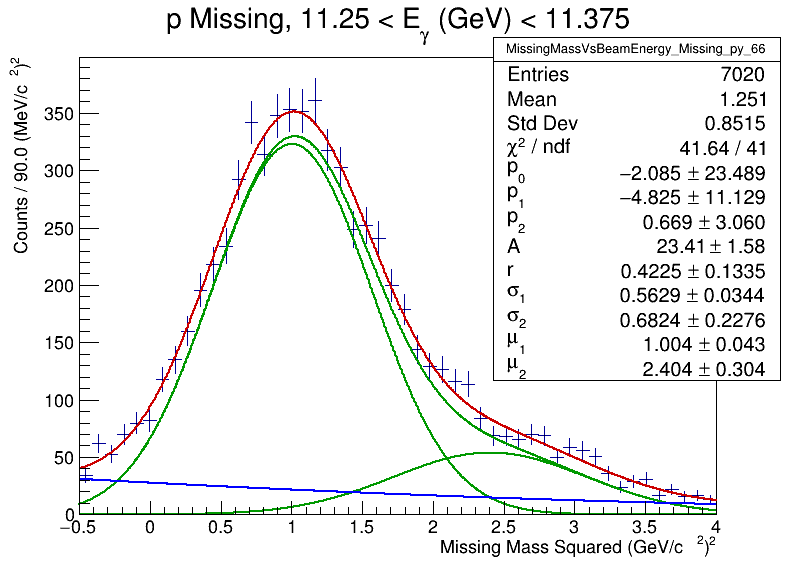

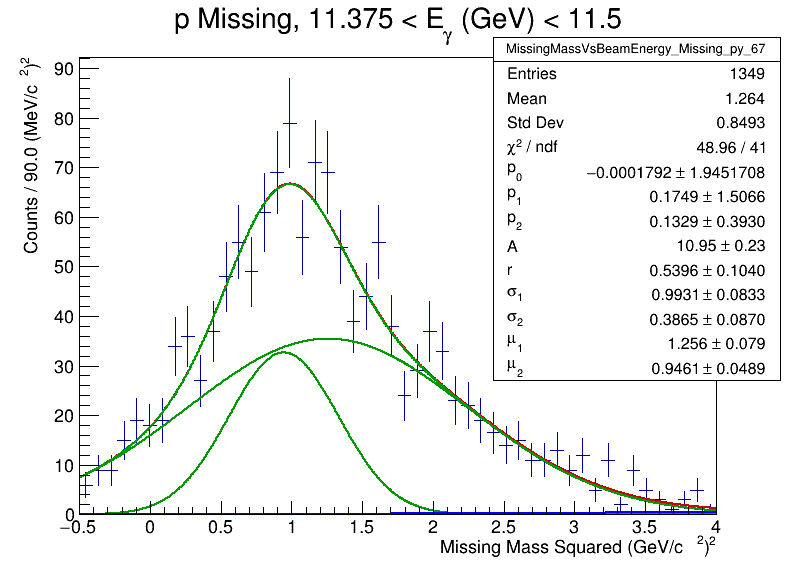

In [13]:
canvs = []
for energyBin, MM2Hist in MM2Hists.items():
  canvs.append(ROOT.TCanvas(f"canv_{energyBin[0]}_{energyBin[1]}", "", 800, 600))
  MM2Hist.Draw()
  canvs[-1].Draw()

# Scratchpad

In [ ]:
# see https://root-forum.cern.ch/t/syntax-of-a-free-function-or-c-functor-for-tgraph-fitting/22292/3
# and https://root.cern/manual/python/#just-in-time-compilation-of-small-strings
ROOT.gInterpreter.ProcessLine('''
struct MyFunction {
  MyFunction() { }

  double operator() (double* vars, double* pars)
  {
    const double x  = vars[0];
    const double p0 = pars[0];
    const double p1 = pars[1];
    const double p2 = pars[2];

    const double linTerm = p1 + p2 * x;
    return p0 * p0 + linTerm * linTerm;
  }
};
''')
myFunc = ROOT.MyFunction()
func = ROOT.TF1("func", myFunc, -1, 1, 3)
# make function visible in Cling's global scope so it can be used in TFormula
# see https://root-forum.cern.ch/t/advanced-tformula-and-tf1-usage/36643/2
ROOT.gInterpreter.ProcessLine("TF1& func = *((TF1*)gROOT->GetFunction(\"func\"))")
#!!! parameter setting in TFormula expression does not work
fooFunc = ROOT.TF1("fooFunc", "func(x)", -1, 1, 3)
fooFunc.SetParameter(0, -1)
fooFunc.SetParameter(1, -2)
fooFunc.SetParameter(2, -3)
# fooFunc = ROOT.TF1("fooFunc", "func(x, [2..4])", -1, 1, 5)
# fooFunc.SetParameter(0, 10)
# fooFunc.SetParameter(1, -5)
# fooFunc.SetParameter(2, -1)
# fooFunc.SetParameter(3, -2)
# fooFunc.SetParameter(4, -3)
# canv = ROOT.TCanvas("canv", "", 800, 600)
fooFunc.Draw()
canv.Draw()